<a href="https://colab.research.google.com/github/tblackfd/Thesis/blob/main/BrandtModelReplication_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background
This notebook intends to replicate the Lifecycle Assessment of geologic hydrogen produced by Brandt (2023) in order to perform a review of its methods and assumptions, as well as the conclusions published in the associated paper.

In [66]:
#Import relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [67]:
# Set seaborn whitegrid style
sns.set_style("whitegrid")

# Input Data Specific to Geologic H2

The following section establishes input data specific to the estimation of emissions from production of geologic hydrogen.

Key assumptions are:
* Well pressure calculated as depth (in ft) by a factor 0.42
* Initial Baseline raw gas rate is given (23,100 MSCFD) and declines at a manually-defined rate.
* Low pressure case is assumed to be 75% of baseline
* High pressure case is assumed to be 125% of baseline
* "High productivity" wellhead pressure is assumed to be 200% of baseline
* "Deep" and "Shallow" pressures are calculated based on assumed depths of 12,000 and 1,500 ft, respectively.

# Constants/Assumptions for Calculations

In [68]:
GWP_H2 = 5 #Global Warming Potential of H2, relative to CO2, to enable CO2e calculations. From Brandt OPGEE file: "Low value from Derwent et al. 2020, of 5.0. High value of 10.9 from Warwick et al. 2022."
GWP_CH4 = 25 #Global Warming Potential of methane. 100-year basis, IPCC 2007 AR4, per Brand OPGEE file.

LHV_H2 = 113.958057395143 #mmbtu/tonne. OPGEE source listed as Mechanical engineer's handbook - Energy & Power (3rd edition). John Wiley & Sons. Chapter 17: Gaseous Fuels, Table 2
LHV_CH4 = 47.5055187637969 #mmbtu/tonne

#LHV Energy Densities for gases:
data = {
    'Gas': ['N2', 'O2', 'CO2', 'H2O', 'CH4', 'C2H6', 'C3H8', 'C4H10', 'CO', 'H2', 'H2S', 'SO2'],
    'LHV (MJ/kg)': [
        0.0000000000,  # LHV for N2, Ar
        0.0000000000,  # LHV for O2
        0.0000000000,  # LHV for CO2
        0.0000000000,  # LHV for H2O
        50.1206975717,  # LHV for CH4
        47.5867143488,  # LHV for C2H6
        46.4501483444,  # LHV for C3H8
        45.8352847682,  # LHV for C4H10
        10.1242877483,  # LHV for CO
        120.2314484547,  # LHV for H2
        15.2434928256,  # LHV for H2S
        0.0000000000   # LHV for SO2
    ]
}
# Create the DataFrame
LHV_density_gases_metric = pd.DataFrame(data)
# Set 'Gas' as the index instead of a column
LHV_density_gases_metric.set_index('Gas', inplace=True)

steel_density = 0.30 #lb/in^3



# Key Variables / Inputs

In [69]:
### Gas Densities. Define a dataframe:

# Define the data as a dictionary
data = {
    'Gas': ['N2','CO2', 'CH4', 'H2'],
    'Density tonne/MMSCF': [33.480353, 52.605153, 19.1738073, 2.4097248]
}

# Create the DataFrame
gas_densities = pd.DataFrame(data)

# Set 'Gas' as the index instead of a column
gas_densities.set_index('Gas', inplace=True)

#Assume all cases produce 0.1 bbl/day of oil:
oil_production_baseline = 0.1 #bbl/day
water_production_baseline = 1 #bbl/mmscf of gas

field_lifespan = 30 #years

small_source_emissions_percentage = 10 #%

# Define/Assume Reservoir Conditions for Analysis

In [70]:
# Data for the Reservoir Conditions DataFrame
reservoir_data = {
    'Case': ['Baseline', 'Low Productivity', 'High Productivity', 'High CH4', 'Mixed', 'Low H2', 'Low H2 w/ CH4', 'Low H2 w/ N2', 'High H2', 'Deep', 'Shallow'],
    'Raw Gas EUR, BCF': [67, 33, 167, 67, 67, 33, 67, 67, 67, 67, 33],
    'H2 EUR, BCF': [57, 28, 142, 57, 57, 28, 57, 57, 57, 57, 28],
    'Depth, ft': [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 12000, 1500],
    'Initial Reservoir Pressure, psi': [2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 5040, 630]
}

# Data for the Gas Composition DataFrame
gas_composition_data = {
    'Case': ['Baseline', 'Low Productivity', 'High Productivity', 'High CH4', 'Mixed', 'Low H2', 'Low H2 w/ CH4', 'Low H2 w/ N2', 'High H2', 'Deep', 'Shallow'],
    'H2': [85.0, 85.0, 85.0, 85.0, 85.0, 75.0, 75.0, 75.0, 95.0, 85.0, 85.0],
    'N2': [12.0, 12.0, 12.0, 1.5, 8.5, 20.0, 0.0, 22.5, 4.0, 12.0, 12.0],
    'CH4': [1.5, 1.5, 1.5, 12.0, 5.0, 2.5, 22.5, 0.0, 0.5, 1.5, 1.5],
    'C2+': [0.0] * 11,
    'CO2': [0.0] * 11,
    'Ar/oth inert': [1.5, 1.5, 1.5, 1.5, 1.5, 2.5, 2.5, 2.5, 0.5, 1.5, 1.5]
}

# Data for the Development Parameters DataFrame
development_params_data = {
    'Case': ['Baseline', 'Low Productivity', 'High Productivity', 'High CH4', 'Mixed', 'Low H2', 'Low H2 w/ CH4', 'Low H2 w/ N2', 'High H2', 'Deep', 'Shallow'],
    'Total Producing Wells': [50] * 11,
    'No. of Compressors': [2] * 11,
    'No. of Purification Plants': [1] * 11,
    'Water Cut (bbl/mmscf)': [1] * 11,
    'H2 purification loss rate': [10] * 11,
    'BCF per well': [1.3, 0.33, 2.0, 1.0, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.0]
}

# Creating the DataFrames & setting 'Case' as the index to make slicing based on Case easier
reservoir_df = pd.DataFrame(reservoir_data)
reservoir_df.set_index('Case', inplace=True)

gas_composition_df = pd.DataFrame(gas_composition_data)
gas_composition_df.set_index('Case', inplace=True)

development_params_df = pd.DataFrame(development_params_data)
development_params_df.set_index('Case', inplace=True)

# # Display the DataFrames (Optional)
# print("Reservoir Conditions DataFrame:")
# print(reservoir_df)
# print("\nGas Composition DataFrame:")
# print(gas_composition_df)
# print("\nDevelopment Parameters DataFrame:")
# print(development_params_df)


In [71]:
#Now define the assumed production profile over the life of each well

# Constants
pressure_coefficient = 0.42
pressure_decline_rate = 0.95
rate_decline_factors = np.array([
    0.3, 0.2, 0.15, 0.125, 0.125, 0.1, 0.1, 0.09, 0.08, 0.07,
    0.07, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03,
    0.03, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02
])
rate_decline_factors = rate_decline_factors[:30]  # Ensure it has exactly 30 elements

# Extract depths for Baseline, Deep, and Shallow from the reservoir_df
depths = reservoir_df['Depth, ft']

# Initial values calculated by depth
initial_wellhead_pressure_baseline = depths['Baseline'] * pressure_coefficient
initial_deep_pressure = depths['Deep'] * 0.43
initial_shallow_pressure = depths['Shallow'] * 0.43

# DataFrame initialization
production_profile_df = pd.DataFrame({
    'Year': range(1, 31),
    'Baseline Raw Gas Rate, MSCFD': [23100] * 30,  # Baseline raw gas rate
    'Baseline Wellhead Pressure, PSI': [initial_wellhead_pressure_baseline] * 30,
    'Deep Pressure, PSI': [initial_deep_pressure] * 30,
    'Shallow Pressure, PSI': [initial_shallow_pressure] * 30
})

# Calculate the baseline raw gas rate and wellhead pressure for each year
for year in range(1, 30):  # Skip the first year as the initial values are already set
    production_profile_df.loc[year, 'Baseline Raw Gas Rate, MSCFD'] = production_profile_df.loc[year - 1, 'Baseline Raw Gas Rate, MSCFD'] * (1 - rate_decline_factors[year-1])
    production_profile_df.loc[year, 'Baseline Wellhead Pressure, PSI'] = production_profile_df.loc[year - 1, 'Baseline Wellhead Pressure, PSI'] * pressure_decline_rate
    production_profile_df.loc[year, 'Deep Pressure, PSI'] = production_profile_df.loc[year - 1, 'Deep Pressure, PSI'] * pressure_decline_rate
    production_profile_df.loc[year, 'Shallow Pressure, PSI'] = production_profile_df.loc[year - 1, 'Shallow Pressure, PSI'] * pressure_decline_rate

# Update other pressures based on the baseline wellhead pressure
production_profile_df['Low Pressure Wellhead Pressure, PSI'] = production_profile_df['Baseline Wellhead Pressure, PSI'] * 0.75
production_profile_df['High Pressure Wellhead Pressure, PSI'] = production_profile_df['Baseline Wellhead Pressure, PSI'] * 1.25

# Update the low and high productivity raw gas rate values
production_profile_df['Low Productivity Raw Gas Rate, MSCFD'] = production_profile_df['Baseline Raw Gas Rate, MSCFD'] * 0.25
production_profile_df['High Productivity Raw Gas Rate, MSCFD'] = production_profile_df['Baseline Raw Gas Rate, MSCFD'] * 2

# Calculate the baseline Gas Oil Ratio (GOR)
production_profile_df['Baseline GOR, SCF/BBL'] = production_profile_df['Baseline Raw Gas Rate, MSCFD'] * 1000 / oil_production_baseline

# Calculate baseline water production in barrels per day
production_profile_df['Water Production, BBL/D'] = production_profile_df['Baseline Raw Gas Rate, MSCFD']/1000 * water_production_baseline

# Calculate the baseline Water Oil Ratio (WOR)
production_profile_df['Baseline WOR'] = production_profile_df['Water Production, BBL/D'] / oil_production_baseline

# Print the DataFrame
production_profile_df.head()

,Year,"Baseline Raw Gas Rate, MSCFD","Baseline Wellhead Pressure, PSI","Deep Pressure, PSI","Shallow Pressure, PSI","Low Pressure Wellhead Pressure, PSI","High Pressure Wellhead Pressure, PSI","Low Productivity Raw Gas Rate, MSCFD","High Productivity Raw Gas Rate, MSCFD","Baseline GOR, SCF/BBL","Water Production, BBL/D",Baseline WOR
0,1,23100.00,2520.00000,5160.00000,645.000000,1890.000000,3150.000000,5775.0000,46200.0,231000000.0,23.10000,231.0000
1,2,16170.00,2394.00000,4902.00000,612.750000,1795.500000,2992.500000,4042.5000,32340.0,161700000.0,16.17000,161.7000
2,3,12936.00,2274.30000,4656.90000,582.112500,1705.725000,2842.875000,3234.0000,25872.0,129360000.0,12.93600,129.3600
3,4,10995.60,2160.58500,4424.05500,553.006875,1620.438750,2700.731250,2748.9000,21991.2,109956000.0,10.99560,109.9560
4,5,9621.15,2052.55575,4202.85225,525.356531,1539.416812,2565.694687,2405.2875,19242.3,96211500.0,9.62115,96.2115


# Sources of Emissions per Brandt Paper:
Brandt's paper considers that following categories of emissions contribute to the total emissions associated with a geologic hydrogen development:

1.  Operational Combustion
1.  Operational Venting, Flaring and Fugitive Emissions (VFF)
1.  Drilling energy-use and VFF
1.  Emissions embodied in wellbore construction materials and surface equipment
1.  "Other" offsite emissions
1.  "Small sources" of emissions, not significant enough to be modelled individually but included as course, aggregated estimates.

The following sections will consider each of these emissions categories and replicate the accounting for these sources.







# 1: Operational Combustion Emissions (kg CO2e/d)

Total operational combustion emissions are those associated with combustion during operation. These are only relevant in certain cases. In the baseline case, it is assumed that a portion of the produced H2 is used to provide power for compression (both upstream of gas treatment and upstream of waste gas re-injection), dehydration, and pressure-swing adsorption (PSA) separation.

Hydrogen combustion is assumed to have no CO2e emissions, so the baseline case has no Operational Combustion Emissions.

Other cases (e.g. high CH4 fields, where the CH4 is "self used" for the processes listed above) will have Operational Combustion Emissions. These will be assessed after replicating the baseline conditions.

In [72]:
baseline_operational_combustion_emissions = 0 #kg CO2e/d

# 2: Operational Venting, Flaring and Fugitive Emissions (VFF)

Brandt paper: "VFF emissions include all purposeful (vented) and un-purposeful (fugitive) emissions from process units and piping."

Each of sub-category (i.e. venting, flaring, or fugitive) is calculated individually, per each of the following process stages:

1.   Production & Extraction
2.   Surface Processing

The following two sub-categories are associated with VFF-type emissions, however these are separated out into a separate section. See Section 3, below.

3.   Exploration
4.   Drilling & Development

The following sub-categories are included in the full OPGEE analysis model, but are not considered relevant to geologic H2 production:

5.   Liquefied Natural Gas
6.   Maintenance
7.   Waste disposal
8.   Crude oil transport and storage
9.   Other Gas transport, storage, and distribution
10.  Electricity generation

Note also that the baseline case does not include any flaring, so it is sufficient to only consider Venting and Fugitive emissions for this specific case.

The following sections detail Venting and Flaring calculations for each of the relevant items above (i.e. Exploration and Drilling & Development).



### 2.1.1 Production & Extraction Venting

The OPGEE tool considers the following potential sources of vented emissions.

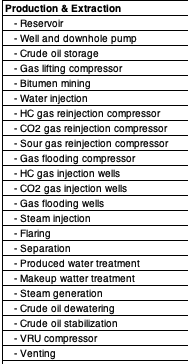

Of these, Brandt's baseline case shows emissions from the "Well and downhole pump", "HC gas reinjection compressor", "HC gas injection wells", and "Separation" process stages. Thus, these calculations are replicated below.

The basis of this calculation is to take the weighted sum (in terms of Global Warming Potential, i.e. ensuring CO2-equivalence) of emissions in each component associated with the "well & downhole pump" part of the system. These components are:


* Fugitives - Completions
    * OPGEE labels this as fugitive, but logic actually classifies these emissions as vents
    * "Total gas lost during completions divided by gas production"
    * OPGEE uses a database of tonnes of fugitive emissions per activity in terms of CO2 and CH4. For Geologic H2, Brandt assumes that total mass of emissions per activity are consistent with the database values, but that the composition of the emissions are aligned with the assumptions regarding the reservoir composition (i.e. high H2, low CH4 and CO2).
* Fugitives - Workovers
    * "Total gas lost during workovers divided by gas production"
    * Assumes total gas for all workovers over field life and then calculates a loss rate as this total divided by total gas production. Loss is apportioned per reservoir composition.
* Pneumatic controllers
    * 0.0000%
    * Loss rate calculated in same manner as wellhead, above.
* Liquids unloadings
    * This loss rate is dependent on gas rate, so needs to be calculated for each year of field life.
* On-site tanks - vents
    * 0.000% - No tanks in design.



In [73]:
#Brandt's model shows that the loss rate at the well head increases as production decreases. These rates are extracted from Brandt's model as follows:

#Loss rates for this section are all based on flow rates downstream of the separator, so first calculate these rates. Create variables for all gases (CH4, H2, N2, CO2) downstream of the separator
#because these are required later, even if they are not considered for vented/fugitive emissions.

CH4_after_separator = (
    gas_composition_df.loc['Baseline', 'CH4'] / 100 *
    oil_production_baseline *
    production_profile_df['Baseline GOR, SCF/BBL'] / 1E6 *
    gas_densities.loc['CH4', 'Density tonne/MMSCF']
)
H2_after_separator = (
    gas_composition_df.loc['Baseline', 'H2'] / 100 *
    oil_production_baseline *
    production_profile_df['Baseline GOR, SCF/BBL'] / 1E6 *
    gas_densities.loc['H2', 'Density tonne/MMSCF']
)
N2_after_separator = (
    gas_composition_df.loc['Baseline', 'N2'] / 100 *
    oil_production_baseline *
    production_profile_df['Baseline GOR, SCF/BBL'] / 1E6 *
    gas_densities.loc['N2', 'Density tonne/MMSCF']
)
CO2_after_separator = (
    gas_composition_df.loc['Baseline', 'CO2'] / 100 *
    oil_production_baseline *
    production_profile_df['Baseline GOR, SCF/BBL'] / 1E6 *
    gas_densities.loc['CO2', 'Density tonne/MMSCF']
)

#First consider venting associated with completions. Calculate CH4 and H2 separately, then calculate their sum.
production_vent_completions_CH4 = 0.0000508137868256929 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * Gas Rate

production_vent_completions_H2 = 0.0000508137868256929 * GWP_H2 * H2_after_separator #Loss Rate * GWP * Gas Rate

production_vent_completions_emissions = production_vent_completions_CH4 + production_vent_completions_H2 #This gives a series of 30 results. i.e. per year of field life.

#Now consider venting associated with workovers. Logic identical to above, but with a slightly different loss rate of 0.0048%
production_vent_workovers_CH4 = 0.000048324093465614 * GWP_CH4 * CH4_after_separator

production_vent_workovers_H2 = 0.000048324093465614 * GWP_H2 * H2_after_separator

production_vent_workovers_emissions = production_vent_workovers_CH4 + production_vent_workovers_H2

#Now looking at the vents associated with Liquids Unloadings:

#Liquids unloadings vary according to rate of production from the field, so baseline loss rates have been extracted from Brandt's model for each year of field life:

liquids_unloadings_percentages = [
    0.022286, 0.035370, 0.045185, 0.045185, 0.047776, 0.069842, 0.075147, 0.075147, 0.075147,
    0.075147, 0.075147, 0.075147, 0.075147, 0.075147, 0.093191, 0.103238, 0.103238, 0.103238,
    0.103238, 0.114288, 0.114288, 0.114288, 0.114288, 0.114288, 0.114288, 0.114498, 0.114498,
    0.114498, 0.114498, 0.114498
]

# Create the DataFrame
df_liquids_unloadings = pd.DataFrame({
    'Year': range(1, 31),
    'Liquids Unloadings %': liquids_unloadings_percentages
})

production_vent_liquids_CH4 = df_liquids_unloadings['Liquids Unloadings %']/100 * GWP_CH4 * CH4_after_separator
production_vent_liquids_H2 = df_liquids_unloadings['Liquids Unloadings %']/100 * GWP_H2 * H2_after_separator

production_vent_liquids_emissions = production_vent_liquids_CH4 + production_vent_liquids_H2

total_production_vent_emissions = production_vent_completions_emissions + production_vent_workovers_emissions + production_vent_liquids_emissions #tCO2e/day

print (total_production_vent_emissions)

0     0.129658
1     0.127640
2     0.124244
3     0.105608
4     0.096752
5     0.117039
6     0.112342
7     0.101108
8     0.092008
9     0.084647
10    0.078722
11    0.073212
12    0.068819
13    0.065378
14    0.076077
15    0.080150
16    0.077746
17    0.075413
18    0.073151
19    0.077886
20    0.075549
21    0.073283
22    0.071817
23    0.070381
24    0.068269
25    0.067017
26    0.065677
27    0.064363
28    0.063076
29    0.061814
dtype: float64


### 2.1.2 Production & Extraction Fugitive

* Fugitives - Wellhead
    * Calculated as fractional loss rate. This loss rate is calculated as the average of emissions of this component under different flowrates (divided into 10 "tranches"), weighted against the relative volume of gas produced in each flowrate tranche.
* On-site meter
    * Loss rate calculated in same manner as wellhead, above.
* On-site dehydrator
    * Loss rate calculated in same manner as wellhead, above.
* On-site reciprocating compressor
    * Loss rate calculated in same manner as wellhead, above.
* On-site heater
    * Loss rate calculated in same manner as wellhead, above.
* On-site header
    * 0.0000%
    * Loss rate calculated in same manner as wellhead, above.
* Chemical injection pumps
    * Loss rate calculated in same manner as wellhead, above.
* On-site tanks - leaks
    * 0.000% - No tanks in design.

In [74]:
wellhead_fugitive_loss_rates = [
    0.073042, 0.102432, 0.130786, 0.130786, 0.134990, 0.179778, 0.195050, 0.195050, 0.195050,
    0.195050, 0.195050, 0.195050, 0.195050, 0.195050, 0.220065, 0.244452, 0.244452, 0.244452,
    0.244452, 0.274038, 0.274038, 0.274038, 0.274038, 0.274038, 0.274038, 0.274519, 0.274519,
    0.274519, 0.274519, 0.274519
]

# Create the DataFrame
df_wellhead_fugitive_loss_rates = pd.DataFrame({
    'Year': range(1, 31),
    'Wellhead Fugitive Losses %': wellhead_fugitive_loss_rates
})

production_fugitive_wellhead_CH4 = df_wellhead_fugitive_loss_rates['Wellhead Fugitive Losses %']/100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_wellhead_H2 = df_wellhead_fugitive_loss_rates['Wellhead Fugitive Losses %']/100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
production_fugitive_wellhead = production_fugitive_wellhead_CH4 + production_fugitive_wellhead_H2

### Now looking at the meter fugitive losses, which also change over the life of the field:

# Meter fugitive loss rates extracted from Brandt's model
meter_fugitive_loss_rates = [
    0.045713, 0.063821, 0.085305, 0.085305, 0.090005, 0.117416, 0.127744, 0.127744, 0.127744,
    0.127744, 0.127744, 0.127744, 0.127744, 0.127744, 0.152734, 0.164370, 0.164370, 0.164370,
    0.164370, 0.197726, 0.197726, 0.197726, 0.197726, 0.197726, 0.197726, 0.198287, 0.198287,
    0.198287, 0.198287, 0.198287
]

# Create the DataFrame for meter fugitive losses
df_meter_fugitive_losses = pd.DataFrame({
    'Year': range(1, 31),
    'Meter Fugitive Losses %': meter_fugitive_loss_rates
})

production_fugitive_meter_CH4 = df_meter_fugitive_losses['Meter Fugitive Losses %'] / 100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_meter_H2 = df_meter_fugitive_losses['Meter Fugitive Losses %'] / 100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
production_fugitive_meter = production_fugitive_meter_CH4 + production_fugitive_meter_H2

### Dehydrator fugitive loss rates
dehydrator_fugitive_loss_rates = [
    0.001652, 0.002315, 0.003324, 0.003324, 0.003659, 0.004127, 0.005150, 0.005150, 0.005150,
    0.005150, 0.005150, 0.005150, 0.005150, 0.005150, 0.005773, 0.006185, 0.006185, 0.006185,
    0.006185, 0.010305, 0.010305, 0.010305, 0.010305, 0.010305, 0.010305, 0.010315, 0.010315,
    0.010315, 0.010315, 0.010315
]

# Create the DataFrame for dehydrator fugitive losses
df_dehydrator_fugitive_losses = pd.DataFrame({
    'Year': range(1, len(dehydrator_fugitive_loss_rates) + 1),
    'Dehydrator Fugitive Losses %': dehydrator_fugitive_loss_rates
})

# Calculate the CH4 and H2 components of fugitive emissions from dehydrators
production_fugitive_dehydrator_CH4 = df_dehydrator_fugitive_losses['Dehydrator Fugitive Losses %'] / 100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_dehydrator_H2 = df_dehydrator_fugitive_losses['Dehydrator Fugitive Losses %'] / 100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
# Sum the CH4 and H2 components to get the total fugitive emissions from dehydrators
production_fugitive_dehydrator = production_fugitive_dehydrator_CH4 + production_fugitive_dehydrator_H2

### Compressor fugitive losses:

# Compressor fugitive loss rates
compressor_fugitive_loss_rates = [
    0.006438, 0.009546, 0.012612, 0.012612, 0.012981, 0.019398, 0.020913, 0.020913, 0.020913,
    0.020913, 0.020913, 0.020913, 0.020913, 0.020913, 0.028692, 0.031455, 0.031455, 0.031455,
    0.031455, 0.033691, 0.033691, 0.033691, 0.033691, 0.033691, 0.033691, 0.033761, 0.033761,
    0.033761, 0.033761, 0.033761
]

# Create the DataFrame for compressor fugitive losses
df_compressor_fugitives = pd.DataFrame({
    'Year': range(1, len(compressor_fugitive_loss_rates) + 1),
    'Compressor Fugitive Losses %': compressor_fugitive_loss_rates
})

# Calculate the CH4 and H2 components of fugitive emissions from compressors
production_fugitive_compressor_CH4 = df_compressor_fugitives['Compressor Fugitive Losses %'] / 100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_compressor_H2 = df_compressor_fugitives['Compressor Fugitive Losses %'] / 100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
# Sum the CH4 and H2 components to get the total fugitive emissions from compressors
production_fugitive_compressor = production_fugitive_compressor_CH4 + production_fugitive_compressor_H2

### Heater fugitive losses:

# Heater fugitive loss rates
heater_fugitive_loss_rates = [
    0.002672, 0.003710, 0.005876, 0.005876, 0.006623, 0.007484, 0.008829, 0.008829, 0.008829,
    0.008829, 0.008829, 0.008829, 0.008829, 0.008829, 0.010364, 0.011616, 0.011616, 0.011616,
    0.011616, 0.016787, 0.016787, 0.016787, 0.016787, 0.016787, 0.016787, 0.016800, 0.016800,
    0.016800, 0.016800, 0.016800
]

# Create the DataFrame for heater fugitive losses
df_production_fugitive_heater = pd.DataFrame({
    'Year': range(1, 31),
    'Heater Fugitive Losses %': heater_fugitive_loss_rates
})

# Calculate the CH4 and H2 components of fugitive emissions from heaters
production_fugitive_heater_CH4 = df_production_fugitive_heater['Heater Fugitive Losses %'] / 100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_heater_H2 = df_production_fugitive_heater['Heater Fugitive Losses %'] / 100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
# Sum the CH4 and H2 components to get the total fugitive emissions from heaters
production_fugitive_heater = production_fugitive_heater_CH4 + production_fugitive_heater_H2

### Chemical Pump fugitive losses:

# Chemical pumps fugitive loss rates
chempumps_fugitive_loss_rates = [
    0.015471, 0.024089, 0.030308, 0.030308, 0.034018, 0.048136, 0.054173, 0.054173, 0.054173,
    0.054173, 0.054173, 0.054173, 0.054173, 0.054173, 0.068415, 0.080419, 0.080419, 0.080419,
    0.080419, 0.094304, 0.094304, 0.094304, 0.094304, 0.094304, 0.094304, 0.094402, 0.094402,
    0.094402, 0.094402, 0.094402
]

# Create the DataFrame for chemical pumps fugitive losses
df_production_fugitive_chempumps = pd.DataFrame({
    'Year': range(1, 31),
    'Chemical Pumps Fugitive Losses %': chempumps_fugitive_loss_rates
})

# Calculate the CH4 and H2 components of fugitive emissions from chemical pumps
production_fugitive_chempumps_CH4 = df_production_fugitive_chempumps['Chemical Pumps Fugitive Losses %'] / 100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_chempumps_H2 = df_production_fugitive_chempumps['Chemical Pumps Fugitive Losses %'] / 100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate

# Sum the CH4 and H2 components to get the total fugitive emissions from chemical pumps
production_fugitive_chempumps = production_fugitive_chempumps_CH4 + production_fugitive_chempumps_H2

total_production_fugitive_emissions = (
    production_fugitive_wellhead + production_fugitive_meter + production_fugitive_dehydrator +
    production_fugitive_compressor + production_fugitive_heater + production_fugitive_chempumps
)

# print (total_production_fugitive_emissions)

## 2.2.1 Surface Processing Fugitives

Fugitive emissions via surface processing are assumed to only occur as part of 'gas gathering'. This is calculated similarly as in 2.1, above, with a fractional loss rate applied to the gas production rate at the relevant point in the process flow.

In [75]:
gas_gathering_fugitive_rate = 0.00495897945648821 #Taken from OPGEE model. Does not vary with production rate.

gas_gathering_fugitive_CH4 = gas_gathering_fugitive_rate * GWP_CH4 * CH4_after_separator
gas_gathering_fugitive_H2 = gas_gathering_fugitive_rate * GWP_H2 * H2_after_separator
gas_gathering_fugitives = gas_gathering_fugitive_CH4 + gas_gathering_fugitive_H2

print(gas_gathering_fugitives)

0     1.996822
1     1.397775
2     1.118220
3     0.950487
4     0.831676
5     0.727717
6     0.654945
7     0.589450
8     0.536400
9     0.493488
10    0.458944
11    0.426818
12    0.401209
13    0.381148
14    0.365902
15    0.351266
16    0.340728
17    0.330506
18    0.320591
19    0.310973
20    0.301644
21    0.292595
22    0.286743
23    0.281008
24    0.272578
25    0.267126
26    0.261784
27    0.256548
28    0.251417
29    0.246389
Name: Baseline GOR, SCF/BBL, dtype: float64


## 2.2.2 Surface Processing Venting

Vented emissions through surface processing are assumed to only occur as part of gas dehydration (i.e. the glycol unit).



In [76]:
#First calculate the gas flow rates downstream of gas gathering (i.e. upstream of dehydration)
CH4_after_gas_gathering = CH4_after_separator - gas_gathering_fugitive_CH4/GWP_CH4
H2_after_gas_gathering = H2_after_separator - gas_gathering_fugitive_H2/GWP_H2

gas_dehydration_vent_rate = 0.000810912362269712 #Taken from OPGEE model. Does not vary with production rate.

gas_dehydration_vent_CH4 = gas_dehydration_vent_rate * GWP_CH4 * CH4_after_gas_gathering
gas_dehydration_vent_H2 = gas_dehydration_vent_rate * GWP_H2 * H2_after_gas_gathering
gas_dehydration_vents = gas_dehydration_vent_CH4 + gas_dehydration_vent_H2

# print(gas_dehydration_vents)

In [77]:
#For later use, now calculate the gas flows remaining downstream of the dehydration system:

CH4_after_dehy = CH4_after_gas_gathering - gas_dehydration_vent_CH4/GWP_CH4
H2_after_dehy = H2_after_gas_gathering - gas_dehydration_vent_H2/GWP_H2

## 2.3 HC gas reinjection compressor

The Brandt paper assumes that non-H2 captured waste streams are compressed and re-injected into the subsurface. This factor estimates the amount of fugitive emissions through the compressor sub-system.



In [78]:
#Contribution is small, so for the time being just take the number from the OPGEE model directly.
HC_gas_reinjection_compressor_fugitives = 0.00743937294627298 #tCO2eq/d    

## 2.4 HC gas injection wells

Paper assumes certain amount of fugitive emissions downstream of the reinjection compressors, at the injection wells.

In [79]:
#Contribution is small, so for the time being just take the number from the OPGEE model directly.
HC_gas_reinjection_well_fugitives = 0.0813978368107571 #tCO2eq/d

## 2.5 Separation

In [80]:
# Separation fugitive loss rates
separation_fugitive_loss_rates = [
    0.00061497, 0.000923162, 0.001252111, 0.001252111, 0.001281899,
    0.001694345, 0.001873018, 0.001873018, 0.001873018, 0.001873018,
    0.001873018, 0.001873018, 0.001873018, 0.001873018, 0.002178708,
    0.002287947, 0.002287947, 0.002287947, 0.002287947, 0.002862778,
    0.002862778, 0.002862778, 0.002862778, 0.002862778, 0.002862778,
    0.002867841, 0.002867841, 0.002867841, 0.002867841, 0.002867841
]

# Create the DataFrame for separation fugitive losses
df_separation_fugitive = pd.DataFrame({
    'Year': range(1, 31),
    'Separation Fugitive Losses %': separation_fugitive_loss_rates
})

# Calculate CH4 and H2 fugitive emissions and their total
production_separation_fugitive_CH4 = df_separation_fugitive['Separation Fugitive Losses %'] * GWP_CH4 * CH4_after_separator #Possibly factor of 100 out, due to conversion from percentage?
production_separation_fugitive_H2 = df_separation_fugitive['Separation Fugitive Losses %']  * GWP_H2 * H2_after_separator #Possibly factor of 100 out, due to conversion from percentage?
production_separation_fugitives = production_separation_fugitive_CH4 + production_separation_fugitive_H2

#Now calculate losses for N2 and CO2, which are not considered in the above calculations:
N2_separation_losses = df_separation_fugitive['Separation Fugitive Losses %'] * N2_after_separator #Possibly factor of 100 out, due to conversion from percentage?
CO2_separation_losses = df_separation_fugitive['Separation Fugitive Losses %'] * CO2_after_separator #Possibly factor of 100 out, due to conversion from percentage?

# print(production_separation_fugitives)

## 2.6 Total operational VFF emissions
This is the sum total of the calculations in Sections 2.1 and 2.2, above.


In [81]:
total_operational_VFF_emissions = (
    production_vent_completions_emissions +
    production_vent_workovers_emissions +
    production_vent_liquids_emissions +
    production_fugitive_wellhead +
    production_fugitive_meter +
    production_fugitive_dehydrator +
    production_fugitive_compressor +
    production_fugitive_heater +
    production_fugitive_chempumps +
    gas_gathering_fugitives +
    gas_dehydration_vents +
    HC_gas_reinjection_compressor_fugitives +
    HC_gas_reinjection_well_fugitives +
    production_separation_fugitives
) *1000

# print(total_operational_VFF_emissions)

# print(production_vent_completions +
#     production_vent_workovers +
#     production_vent_liquids +
#     production_fugitive_wellhead +
#     production_fugitive_meter +
#     production_fugitive_dehydrator +
#     production_fugitive_compressor +
#     production_fugitive_heater +
#     production_fugitive_chempumps +
#     gas_gathering_fugitives +
#     gas_dehydration_vents +
#     HC_gas_reinjection_compressor_fugitives +
#     HC_gas_reinjection_well_fugitives +
#     production_separation_fugitives
# )

# 3. Drilling Energy-Use & VFF

Brandt's OPGEE analysis combines estimates of emissions from exploration activities together with drilling & development activities. The source of these emissions is assumed to be limited to the running of diesel engines required to complete these activities.

## 3.1 Exploration

Brandt's paper assumes that the only emissions associated with exploration is combustion in diesel engines. He estimates the energy consumption from survey vehicles (assumed to be heavy duty trucks for onshore assets), the expected emissions from drilling activities, and then calculates a ratio of expected total energy consumption from these two sources to the expected total energy produced from the the H2 in the field ("Fractional Energy Consumption").

Separately, the daily production rate of the asset (in energy terms) is calculated (i.e. H2 leaving the PSA unit). Daily energy consumed burning diesel is thus the Fractional Energy Consumption ratio multiplied by the daily production rate. Daily energy consumption is converted to daily emissions by multiplying by an 'emissions factor' for heavy duty trucks.

Emissions factor is taken from GREET 1_2016, sheet 'EF', Table 2.2 and 2.3, "Emission Factors of Fuel Combustion: Feedstock and Fuel Transportation from Product Origin to Product Destination back to Poduct Origin (grams per mmbtu of fuel burned)".

In [82]:
#First define factors needed in the subsequent calculations
heavy_duty_truck_diesel_intensity = 969 #btu LHV/ton mi (Paper does not cite source of this figure)
weight_land_survey = 25 #tonnes. Weight of land survey vehicle. Default assumption of OPGEE model.
distance_survey = 10000 #miles. Distance of travel for survey. Default assumption of OPGEE model. "Estimate accounting for long-distance travel of specialized equipment"
emissions_factor_trucks = 78908.518237706 #gCO2eq./mmbtu. OPGEE quoting GREET.
emissions_factor_diesel_exploration = 78823.3589186562 #g GHGs/mmbtu LHV. OPGEE quoting GREET, but using the values for "Barge diesel" rather than "Truck Diesel". It is unclear to me why this is the case.
emissions_factor_diesel_drilling = 78490.5078472298 #g GHGs/mmbtu LHV. OPGEE quoting GREET, but using the values for "Barge diesel" rather than "Truck Diesel". It is unclear to me why this is the case.

#Pre-production Wells:
number_dry_wells = 1 #Number of dry wells drilled per discovered field.
number_exploration_wells = 3 #Number of exploratory/scientific wells drilled after discovery of the field.
diesel_energy_density = 128450 #LHV btu/gal. Source: GREET1_2016, obtained from "Fuel_Specs" worksheet.

#Production Wells:
number_production_wells = 50 #Key assumption
number_injection_wells = math.ceil(0.25*number_production_wells) #Assumption. Rounding up, as you can't drill a fraction of a well.
total_number_wells = number_production_wells + number_injection_wells
print(total_number_wells)
field_depth = depths['Baseline']
drilling_fuel_per_foot_vertical = 0.325964356060972 #gal diesel fuel/ft. This figure taken direct from OPGEE model and assumes Moderate complexity wells drilled at Medium efficiency.

drilling_diesel_consumption = drilling_fuel_per_foot_vertical * field_depth * total_number_wells #Brandt paper assumes all wells are vertical, so can ignore calcs relating to horizontal drilling.
drilling_energy_consumption_by_field = drilling_diesel_consumption * diesel_energy_density/1E6 #mmbtu LHV

energy_intensity_per_well = drilling_energy_consumption_by_field / total_number_wells

survey_vehicle_energy_consumption = heavy_duty_truck_diesel_intensity * weight_land_survey * distance_survey / 1E6
drilling_energy_consumption = (number_dry_wells + number_exploration_wells) * energy_intensity_per_well

daily_field_H2_exported = H2_after_dehy * 0.9 #tonnes/day. It is assumed that 10% of H2 entering the PSA unit is lost.

daily_energy_from_produced_oil = 0.475092430879946 #mmBTU/day. This is the energy content of the oil produced, as calculated in the OPGEE model.

daily_field_energy_exported = daily_field_H2_exported * LHV_H2 + daily_energy_from_produced_oil  #mmbtu/day. Energy exported is just the H2 that leaves the processing facility, i.e. Mass * heating value.

lifetime_field_energy_production = daily_field_energy_exported * 365 * field_lifespan

#Now calculate the fraction of energy spent while exploring to the total saleable energy exported from the asset:
fractional_energy_consumption = (survey_vehicle_energy_consumption + drilling_energy_consumption) / lifetime_field_energy_production

#The rate of GHG emissions per unit of energy produced is thus:
exploration_GHG_emission_rate = fractional_energy_consumption * emissions_factor_trucks #gCO2 eq./mmbtu crude

#Next, the equivalent daily energy use is the fractional rate of energy consumption multiplied by the daily energy production:
exploration_daily_energy_use = fractional_energy_consumption * daily_field_energy_exported

#Finally, the emissions attributed to exploration is the daily energy use, multiplied by the relevant emissions factor:
exploration_emissions = exploration_daily_energy_use * emissions_factor_diesel_exploration / 1E6 #tCO2eq/d

# print(exploration_emissions)
# print(exploration_daily_energy_use)


63


## 3.2 Drilling & Development

This section takes a very similar approach to Section 3.1. It estimates the energy required (in the from of diesel) to develop the field (i.e. drill 50x production wells plus 13 injection wells) and then uses an emissions factor to convert this energy consumption into GHG emissions. 

In [83]:
#First calculate the total development energy for the entire field. There is no fracturing, so the only energy use is in drilling the wells.
#First step of this calculation is to estimate the drilling fuel consumption:

development_drilling_fuel_consumption = drilling_fuel_per_foot_vertical * field_depth * total_number_wells
#Next, calculate the energy content of this fuel:
development_drilling_energy_consumption = development_drilling_fuel_consumption * diesel_energy_density / 1E6 #mmbtu LHV
#Next, calculate the wellhead energy production of the field. This is comprised of energy of gas at the wellhead, plus the energy content of oil at the wellhead:
#Need to calculate the mass of gas at the wellhead. This is derived by adding the losses during separation to the flows out of the separation unit
CH4_upstream_separator = CH4_after_separator + production_separation_fugitive_CH4/GWP_CH4
H2_upstream_separator = H2_after_separator + production_separation_fugitive_H2/GWP_H2
N2_upstream_separator = N2_after_separator + N2_separation_losses
CO2_upstream_separator = CO2_after_separator + CO2_separation_losses
total_gas_mass_flow_upstream_separator = CH4_upstream_separator + H2_upstream_separator + N2_upstream_separator + CO2_upstream_separator

#Now determine the energy density of the gas produced. This is a weighted average of the energy densities of the individual gases, weighted by their mass fractions.
gas_energy_density = (CH4_upstream_separator * LHV_density_gases_metric.loc['CH4','LHV (MJ/kg)'] + H2_upstream_separator * LHV_density_gases_metric.loc['H2','LHV (MJ/kg)'] + N2_upstream_separator * LHV_density_gases_metric.loc['N2','LHV (MJ/kg)'] + CO2_upstream_separator * LHV_density_gases_metric.loc['CO2','LHV (MJ/kg)']) / total_gas_mass_flow_upstream_separator
wellhead_gas_energy = total_gas_mass_flow_upstream_separator * 1000 * gas_energy_density / 1055.05 #mmbtu/day. This is the energy content of the gas produced, as calculated in the OPGEE model.
wellhead_oil_energy = 0.517752042726451 #mmbtu/day. This is the energy content of the oil produced, as calculated in the OPGEE model.
wellhead_total_energy = wellhead_gas_energy + wellhead_oil_energy

#Now calculate the energy use as a fraction of the total energy produced and convert to emissions:
development_drilling_energy = development_drilling_energy_consumption * wellhead_total_energy / lifetime_field_energy_production #mmbtu/day
development_drilling_emissions = development_drilling_energy * emissions_factor_diesel_drilling / 1E6 #tCO2eq/d
print(development_drilling_energy)



0     1.710879
1     1.711400
2     1.711958
3     1.711954
4     1.712001
5     1.712701
6     1.713002
7     1.712998
8     1.712993
9     1.712989
10    1.712985
11    1.712980
12    1.712976
13    1.712973
14    1.713492
15    1.713676
16    1.713673
17    1.713671
18    1.713668
19    1.714648
20    1.714645
21    1.714642
22    1.714640
23    1.714638
24    1.714635
25    1.714642
26    1.714640
27    1.714638
28    1.714636
29    1.714633
dtype: float64


# 4. Embodied Emissions

Embodied emissions are those emmisions associated with the production of the physical equipment that is installed to enable production of the geologic H2. Given the assumption of no fracturing of wells, the relevant material categories are as follows:

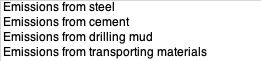

These will be considered in the following sections.

In general, the Brandt model takes the approach of calculating the total embodied emissions associated with the field, then linking this to the daily oil production rate (which is typically assumed to be constant over field life). This effectively spreads the lifecycle emissions evenly over the life of the field. This is not representative of the environmental impacts of these emissions, most of which will be released during offsite manufacturing of equipment (i.e. prior to the start of field life), with a portion associated with field abandonment being released close to the end of field life. The Brandt approach should be reviewed against a standard method for accounting for embodied emissions over time, if such a standard exists. This method means that embodied emissions are independent of flow rate and pressure (which decrease over field life), but equipment must be sized for the most demanding design case (i.e. typicall early field life with high pressure and flow).

## 4.1 Emissions from steel

Steel is used in several parts of the assumed development:
* Wellbore Construction (both for production and injection wells)
* Production & Surface Processing Facilities
* Ancilliary Structures (i.e. Tanks)
* Export Pipelines
* Gathering System Piping

### 4.1.1 Wellbore Construction Steel Emissions

OPGEE model parameterises well construction. In the absense of more specific design details, it defaults to 'moderate' assumptions, as shown below:

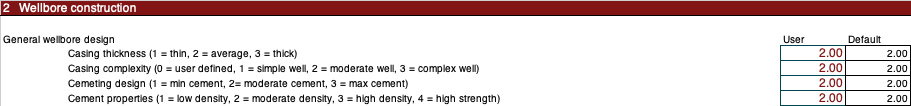

High-level casing design of the moderate well is as per image below. OPGEE quotes the source of this design as: Nguyen, J.P. Drilling (1996) Oil and Gas Field Development Techniques, p. 37 for Parentis oil field, modified to recognize OPGEE default.

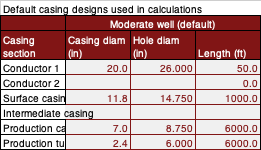

The OPGEE model then uses assumed masses of steel per unit length of casing and production tubing to ultimately calculate a total mass of steel per well.

In [84]:
#First calculate the steel requirements for the 50x production wells:

conductor_diameter = 20 #in 
conductor_length = 50 #ft
surface_casing_diameter = 11.75 #in
surface_casing_length = 1000 #ft
production_casing_diameter = 7 #in
production_casing_length = 6000 #ft
production_tubing_diameter = 2.375 #in
production_tubing_length = 6000 #ft

# Create dataframes for casing and tubing mass data
casing_mass_lookup_data = {
    'Outside Diameter (in)': [
        4.500, 5.000, 5.500, 6.625, 7.000, 7.625, 8.625, 9.625, 
        10.750, 11.750, 13.375, 16.000, 18.625, 20.000, 30.000
    ],
    'Steel Casing Mass per Unit Length (lb/ft)': [
        11.28, 14.38, 17.08, 13.25, 27.50, 28.80, 36.14, 40.23,
        50.12, 48.20, 60.70, 77.60, 87.50, 94.00, 168.06
    ]
}
casing_mass_lookup = pd.DataFrame(casing_mass_lookup_data)
casing_mass_lookup.set_index('Outside Diameter (in)', inplace=True)

tubing_mass_lookup_data = {
    'Nominal Diameter (in)': [0.750, 1.000, 1.250, 1.500, 2.375, 2.875, 3.500, 4.000, 4.500],
    'Tubing Mass per Unit Length (lb/ft)': [1.14, 1.70, 2.30, 2.75, 4.90, 7.50, 10.20, 9.50, 12.60]
}
tubing_mass_lookup = pd.DataFrame(tubing_mass_lookup_data)
tubing_mass_lookup.set_index('Nominal Diameter (in)', inplace=True)

# Function to calculate mass of casing or tubing
def calculate_casing_or_tubing_mass(diameter, length, lookup_df):
    try:
        # Access the mass per unit length directly using the index and extracting the scalar value
        mass_per_unit_length = lookup_df.loc[diameter, lookup_df.columns[0]]
        # Calculate the total mass
        total_mass = mass_per_unit_length * length
        return total_mass
    except KeyError:
        return 0  # Return 0 if the diameter is not found

# Example usage
conductor_mass = calculate_casing_or_tubing_mass(conductor_diameter, conductor_length, casing_mass_lookup)
surface_casing_mass = calculate_casing_or_tubing_mass(surface_casing_diameter,surface_casing_length, casing_mass_lookup)
production_casing_mass = calculate_casing_or_tubing_mass(production_casing_diameter, production_casing_length, casing_mass_lookup)
production_tubing_mass = calculate_casing_or_tubing_mass(production_tubing_diameter, production_tubing_length, tubing_mass_lookup)

# Sum up total mass for each production well and then calculate total mass for all production wells
production_well_steel_mass_individual = (conductor_mass + surface_casing_mass + production_casing_mass + production_tubing_mass) 
production_well_steel_mass_total = production_well_steel_mass_individual * number_production_wells

#Assuming injection wells are the same as production wells, calculate the total steel mass for all wells:
total_steel_mass_all_wells = production_well_steel_mass_individual * total_number_wells #This is the value if all wells are identical, regardless of production or injection.
injection_well_steel_mass_brandt = production_well_steel_mass_total * 0.25/1.25 #This is the manner Brandt calculates injection well steel mass
total_steel_mass_all_wells_brandt = production_well_steel_mass_total + injection_well_steel_mass_brandt

print("Production well total Mass per Brandt:", total_steel_mass_all_wells_brandt, "lb")
print("Production well total Mass if all wells are identical:", total_steel_mass_all_wells, "lb")

Production well total Mass per Brandt: 14838000.0 lb
Production well total Mass if all wells are identical: 15579900.0 lb


### 4.1.2 Production & Surface Processing Facilities Steel Emissions

This section estimates the quantity of steel, and its associated emissions, required for the following surface processing equipment items/sub-systems:
* Surface tubing
* Separators
* Gas sweetening equipment
* Gas dehydration equipment
* Gas compression equipment
* Gas separation via Pressure Swing Adsorption (PSA)

#### 4.1.2.1 Surface Tubing

Here, Brandt takes the OPGEE default values for the surface tubing, which are stated below. It assumes std weight tubing, based on a lookup table from  "Oilfield data handbook", Apex Distribution Inc.
Brandt assumes that tubing is only required for the production wells, not the injection wells. This is a curious assumption, as injection wells would also require tubing. Calculations for both just production wells and all wells are included below.

In [85]:
surface_tubing_avg_diameter = 2.00 #in
surface_tubing_strength_class = 'std'
surface_tubing_weight_per_ft = 3.653 #lb/ft
surface_tubing_avg_length_per_well = 250 #ft/well
surface_tubing_total_mass_all_wells = surface_tubing_weight_per_ft * surface_tubing_avg_length_per_well * total_number_wells #lb
surface_tubing_total_mass_brandt = surface_tubing_weight_per_ft * surface_tubing_avg_length_per_well * number_production_wells #lb

print("Mass of surface tubing assuming all wells:", surface_tubing_total_mass_all_wells, "lb")
print("Mass of surface tubing per Brandt:", surface_tubing_total_mass_brandt, "lb")

Mass of surface tubing assuming all wells: 57534.75 lb
Mass of surface tubing per Brandt: 45662.5 lb


#### 4.1.2.2 Separator(s)

The OPGEE model includes a simple look-up table for separator sizing and throughput based on inlet pressure (From http://www.surfaceequip.com/two-three-phase-vertical-horizontal-separators-gas-scrubbers.html, accessed April 21, 2014) and assumes that it is cheapest to buy a smaller number of larger separators.

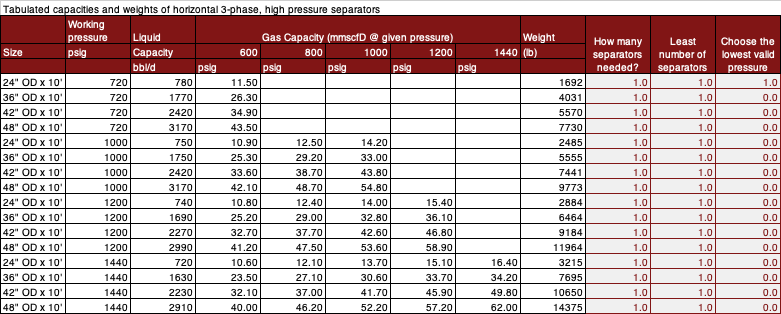

Brandt assumes the smallest separator is installed, despite the pressure at start-of-field-life exceeding the stated working pressure of the 'default' separator. In reality, with such a small volume of produced liquid (relative to gas), it may be that a horizontal separator is not effective in achieving two-phase (i.e. liquid vs gas) separation, let alone three-phase separation (i.e. gas, water & oil).

For the time being, I will retain Brandt's assumption of a single separator of the smallest size provided in the OPGEE default table (noting the provided reference is now defunct).

In [86]:
separator_nominal_weight = 1692 #lb
separator_multiplier_additional_material = 1.5
separator_total_weight = separator_nominal_weight * separator_multiplier_additional_material #lb

print(separator_total_weight)

2538.0


#### 4.1.2.3 Gas sweetening equipment

Gas sweetening (aka acid gas removal, AGR) equipment is that which strips 'sour' CO2 and H2S from the product gas stream. 

Design operates assuming that pressure entering the sub-system is controlled to operating pressure of 500psi. 

Brandt's analysis adopts the default design assumptions for an AGR unit, as shown below:

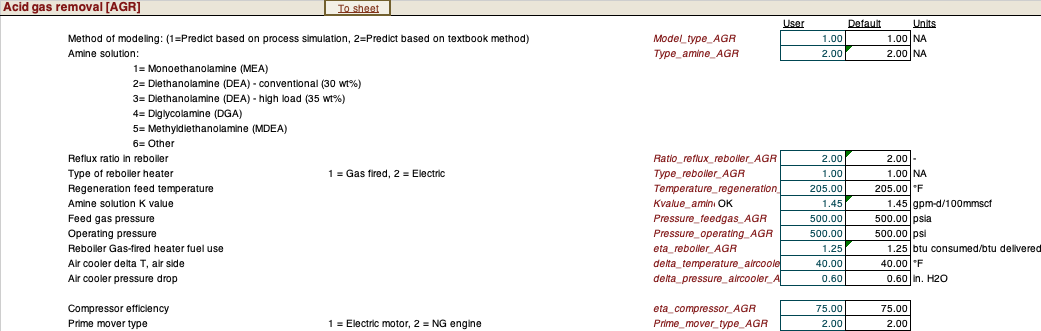

In [87]:
#First define a function to calculate absorber inner diameter based on the logic in OPGEE, which cites data from Manning and Thompson (1991), derived from Khan and Manning (1985).

def calculate_absorber_inner_diameter(pressure, gas_flow_rate):
    if pressure <= 200:
        return 12.259 * gas_flow_rate ** 0.4932
    elif 200 < pressure <= 500:
        return 12.259 * gas_flow_rate ** 0.4932
    elif 500 < pressure <= 1000:
        return 8.6115 * gas_flow_rate ** 0.479
    elif 1000 < pressure <= 1500:
        return 8.6115 * gas_flow_rate ** 0.479
    else:
        raise ValueError("Pressure cannot be greater than 1500 psig")
    
#Now call the function to return the absorber inner diameter for this case:

absorber_operating_pressure = 500 #psig. The OPGEE model assumes pressure is controlled to this point.
absorber_height = 30 #ft. Assumed height of absorber. This is a default assumption in the OPGEE model.
absorber_shell_thickness = 0.5 #in. Assumed thickness of absorber shell. This is a default assumption in the OPGEE model.
absorber_shell_steel_density = 20.4 #lb/ft^2 for 0.5 in thick steel. Assumed density of steel for absorber shell. This is a default assumption in the OPGEE model.

#It is not clear if Brandt assumes maximum or minimum gas flow rate for this calculation, so both are calculated here.
max_gas_flow_rate = max(production_profile_df['Baseline Raw Gas Rate, MSCFD']) / 1000 #MMSCFD
min_gas_flow_rate = min(production_profile_df['Baseline Raw Gas Rate, MSCFD']) / 1000 #MMSCFD
print("Maximum Gas Flow Rate:", max_gas_flow_rate)
print("Minimum Gas Flow Rate:", min_gas_flow_rate)

absorber_inner_diameter_max_gas_flow = calculate_absorber_inner_diameter(absorber_operating_pressure, max_gas_flow_rate)
absorber_inner_diameter_min_gas_flow = calculate_absorber_inner_diameter(absorber_operating_pressure, min_gas_flow_rate)

print("Absorber Inner Diameter based on max gas flow rate:", absorber_inner_diameter_max_gas_flow, "in")
print("Absorber Inner Diameter based on min gas flow rate:", absorber_inner_diameter_min_gas_flow, "in")

absorber_shell_area = math.pi * absorber_inner_diameter_min_gas_flow/12 * absorber_height + 2*math.pi * (absorber_inner_diameter_min_gas_flow/12/2)**2#ft^2. This is the surface area of the absorber shell, assuming a cylindrical shape with flat ends. Would be more appropriate/realistic to assume elliptical or hemispherical ends.
absorber_shell_mass = absorber_shell_area * absorber_shell_steel_density #lb. This is the mass of steel required to construct the absorber shell.
absorber_aux_mass = absorber_shell_mass #lb. OPGEE assumes that mass of trays, aux piping etc. is equal to the mass of the absorber shell.
absorber_mass = absorber_shell_mass + absorber_aux_mass #lb. This is the total mass of the absorber unit.
desorber_mass = absorber_shell_mass + absorber_aux_mass #lb. This is the total mass of the desorber unit, assumed to be identical to the absorber unit.
ancilliary_materials_factor_absorber = 2 #Assumed factor for ancilliary materials. Default assumption in OPGEE model. i.e. Additional steel mass is twice the mass of that associated with absorber/desorbers.
gas_sweetening_equip_total_mass = (absorber_mass + desorber_mass) * ancilliary_materials_factor_absorber #lb. This is the total mass of the gas sweetening equipment.
print(gas_sweetening_equip_total_mass)

Maximum Gas Flow Rate: 23.1
Minimum Gas Flow Rate: 2.8503209767800843
Absorber Inner Diameter based on max gas flow rate: 57.675115581838114 in
Absorber Inner Diameter based on min gas flow rate: 20.54984979851527 in
27091.96397574401


#### 4.1.2.4 Gas dehydration equipment

OPGEE model assumes that glycol (TEG) dehydration is used to remove water from the product gas stream. OPGEE defaults are used, as per image below:

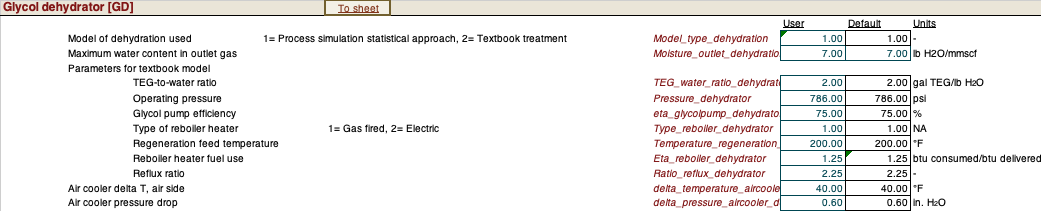

In [88]:
contactor_operating_pressure = absorber_operating_pressure # 500 psig. The OPGEE model assumes pressure is controlled to this point.

#Define a the lookup table used to size the contactor. Notes as to the source of this data are in the OPGEE model.

data = {
    'Pressure (psig)': [400]*13 + [600]*13 + [800]*13 + [1000]*13 + [1200]*13,
    'Throughput (mmscf/d)': [0.0, 3.1, 4.6, 6.8, 14.3, 16.8, 23.4, 25.5, 34.4, 43.6, 53.0, 61.1, 77.4,
                             0.0, 3.7, 5.8, 8.2, 17.5, 20.6, 28.7, 31.2, 42.1, 53.5, 65.3, 79.5, 93.8,
                             0.0, 4.1, 6.6, 9.5, 20.6, 24.0, 33.5, 36.4, 49.2, 62.2, 76.0, 93.0, 110.1,
                             0.0, 4.6, 7.2, 10.4, 23.2, 26.9, 37.7, 41.0, 55.4, 70.1, 86.1, 98.6, 124.9,
                             0.0, 5.0, 7.9, 11.3, 25.5, 29.9, 42.5, 45.8, 61.0, 77.7, 96.0, 108.4, 137.6],
    'OD (in.)': [16.0, 20.0, 24.0, 30.0, 36.0, 42.0, 42.8, 48.8, 54.9, 61.0, 67.1, 73.2, 'NA',
                 16.0, 20.0, 24.0, 30.0, 36.0, 42.0, 43.0, 49.2, 55.3, 61.4, 67.5, 73.6, 'NA',
                 16.0, 20.0, 24.0, 30.0, 36.0, 42.0, 43.3, 49.5, 55.6, 61.8, 67.9, 74.1, 'NA',
                 16.0, 20.0, 24.0, 30.0, 36.0, 42.0, 43.6, 49.8, 56.0, 62.2, 68.4, 74.6, 'NA',
                 16.0, 20.0, 24.0, 30.0, 36.0, 42.0, 43.8, 50.1, 56.3, 62.6, 68.8, 75.0, 'NA'],
    'ID (in.)': [15.6, 19.5, 23.5, 29.4, 35.3, 41.2, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 'NA',
                 15.5, 19.4, 23.3, 29.2, 35.1, 41.0, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 'NA',
                 15.4, 19.3, 23.2, 29.0, 34.8, 40.7, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 'NA',
                 15.3, 19.1, 23.0, 28.8, 34.6, 40.4, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 'NA',
                 15.2, 19.0, 22.9, 28.6, 34.4, 40.2, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 'NA'],
    'Height (ft.)': [15, 15, 15, 20, 20, 20, 25, 25, 25, 30, 30, 30, 'NA',
                     15, 15, 15, 20, 20, 20, 25, 25, 25, 30, 30, 30, 'NA',
                     15, 15, 15, 20, 20, 20, 25, 25, 25, 30, 30, 30, 'NA',
                     15, 15, 15, 20, 20, 20, 25, 25, 25, 30, 30, 30, 'NA',
                     15, 15, 15, 20, 20, 20, 25, 25, 25, 30, 30, 30, 'NA'],
    'Estimated thickness': [0.4, 0.4, 0.5, 0.5, 0.6, 0.7, 0.7, 0.8, 0.9, 0.9, 1.0, 1.1, 'NA',
                            0.5, 0.5, 0.6, 0.7, 0.9, 1.0, 1.0, 1.1, 1.2, 1.3, 1.5, 1.6, 'NA',
                            0.6, 0.7, 0.8, 0.9, 1.1, 1.3, 1.3, 1.4, 1.6, 1.7, 1.9, 2.1, 'NA',
                            0.7, 0.8, 0.9, 1.1, 1.3, 1.5, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 'NA',
                            0.8, 0.9, 1.1, 1.3, 1.6, 1.8, 1.8, 2.0, 2.3, 2.5, 2.7, 3.0, 'NA'],
    'Rounded thickness': [0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.8, 0.8, 0.9, 1.0, 1.1, 1.2, 'NA',
                          0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.0, 1.2, 1.3, 1.4, 1.5, 1.6, 'NA',
                          0.6, 0.7, 0.8, 1.0, 1.2, 1.3, 1.3, 1.5, 1.6, 1.8, 1.9, 2.1, 'NA',
                          0.7, 0.9, 1.0, 1.2, 1.4, 1.6, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 'NA',
                          0.8, 1.0, 1.1, 1.4, 1.6, 1.8, 1.8, 2.1, 2.3, 2.6, 2.8, 3.0, 'NA']
}

# Create the DataFrame
contactor_sizing_lookup = pd.DataFrame(data)



In [89]:
def find_contactor_sizing(gas_flow_rate, operating_pressure):
    """
    Retrieve the contactor sizing information based on gas flow rate and the closest available pressure that is
    greater than or equal to the specified operating pressure.

    Parameters:
    gas_flow_rate (float): The gas flow rate in mmscf/d.
    operating_pressure (int): The operating pressure in psig.

    Returns:
    tuple: Returns a tuple containing the ID, OD, height, and rounded thickness, or a message if no match is found.
    """
    # Filter DataFrame to find the minimum pressure that is greater than or equal to the specified operating pressure
    available_pressures = contactor_sizing_lookup['Pressure (psig)'].unique()
    # Find pressures greater than or equal to the operating_pressure and take the minimum of those
    possible_pressures = available_pressures[available_pressures >= operating_pressure]
    if possible_pressures.size == 0:
        return "No available pressure equal to or greater than the specified pressure."

    closest_pressure = possible_pressures.min()

    # Filter the DataFrame for the closest pressure found
    pressure_match = contactor_sizing_lookup[contactor_sizing_lookup['Pressure (psig)'] == closest_pressure]

    # Find the row with the closest throughput that is greater than or equal to the given gas flow rate
    throughput_match = pressure_match[pressure_match['Throughput (mmscf/d)'] >= gas_flow_rate].sort_values(by='Throughput (mmscf/d)')
    if throughput_match.empty:
        return "No throughput available that matches or exceeds the specified flow rate."

    # Take the closest match based on throughput
    closest_match = throughput_match.iloc[0]

    # Extract the relevant columns
    id_diameter = closest_match['ID (in.)']
    od_diameter = closest_match['OD (in.)']
    height = closest_match['Height (ft.)']
    rounded_thickness = closest_match['Rounded thickness']

    return (id_diameter, od_diameter, height, rounded_thickness)

# Example usage:
contactor_sizing_results = find_contactor_sizing(min_gas_flow_rate, contactor_operating_pressure)
print("ID, OD, Height, Rounded Thickness:", contactor_sizing_results)

contactor_ID = contactor_sizing_results[0]
contactor_OD = contactor_sizing_results[1]
contactor_height = contactor_sizing_results[2]
contactor_thickness = contactor_sizing_results[3]

contactor_shell_volume = math.pi * ((contactor_OD/2)**2 - (contactor_ID/2)**2) * contactor_height * 12 + 2 * math.pi * (contactor_OD/2)**2 * contactor_thickness #in^3. This is the volume of the contactor shell, assuming a cylindrical shape with flat ends. 
# Would be more appropriate/realistic to assume elliptical or hemispherical ends. Note the formula in the OPGEE model for this is incorrect, as it does not include pi in the area of cylinder calculation, nor does it account for any end coverings.
print("Shell Volume:", contactor_shell_volume)
contactor_shell_mass = contactor_shell_volume * steel_density #lb. This is the mass of steel required to construct the contactor shell.

contactor_aux_mass = contactor_shell_mass #lb. OPGEE assumes that mass of trays, aux piping etc. is equal to the mass of the contactor shell. 
ancilliary_materials_factor_contactor = 2 #Assumed factor for ancilliary materials. Default assumption in OPGEE model. i.e. Additional steel mass is twice the mass of that associated with contactor.

dehydration_equip_total_mass = (contactor_shell_mass + contactor_aux_mass) * ancilliary_materials_factor_contactor #lb. This is the total mass of the dehydration equipment.
print('Total mass of dehydration equipment:', dehydration_equip_total_mass,'lb')


ID, OD, Height, Rounded Thickness: (19.4, 20.0, 15, 0.6)
Shell Volume: 3719.0173833196036
Total mass of dehydration equipment: 4462.820859983524 lb


#### 4.1.2.5 Gas reinjection compressor

Brandt assumes that all waste gas is re-injected into the subsurface.

"From relationship for centrifugal compressors from MS thesis of Y. Sun 2015.  Relationship is M = 2887 + 0.7820*Qg, where M is mass of compressor in kg, and Qg is gas flow rate in m3/hr.  Conversion factor of 0.85 is used to convert from mscf/d to m3/hr."

In [90]:
gas_injection_volume = 0.666295945746444 #mscf/d. This is the volume of gas injected. OPGEE calculates this based on assumed reservoir/injection pressure, process pressure, and uses a
#model of adiabatic compression. Adding these calculations is a future improvement to this model.
gas_injection_compressor_mass = (2887 + 0.7820/0.85 * gas_injection_volume) / 0.454 #lb. This is the mass of the gas injection compressor, as calculated in the OPGEE model. 
# Conversion factor of 0.85 is used to convert from mscf/d to m3/hr. 0.454 converts from kg to lb.
gas_injection_aux_mass_factor = 2 #Assumed factor for ancilliary materials. Default assumption in OPGEE model. i.e. Additional steel mass is twice the mass of that associated with gas injection compressor.
gas_injection_total_mass = gas_injection_compressor_mass * gas_injection_aux_mass_factor #lb
print('Total mass of gas injection equipment:', gas_injection_total_mass,'lb')

Total mass of gas injection equipment: 12720.762080484963 lb


#### 4.1.2.6 Gas separation by Pressure Swing Adsorption (PSA)

According to Brandt, PSA is considered standard technology for gas separation in hydrogen production. PSA is not included in the default OPGEE model, so Brandt just assumes a multiple of separator mass.

In [91]:
PSA_unit_mass = separator_total_weight * 5 #lb. This is the mass of the PSA unit, as calculated in the OPGEE model.
print('Total mass of PSA unit:', PSA_unit_mass,'lb')

Total mass of PSA unit: 12690.0 lb


### 4.1.3 Ancilliary Structures Steel Emissions

The OPGEE defaults for "ancilliary structures and construction" include only steel tanks for oil and produced water storage. Produced water storage is excluded in the hydrogen study. The default assumptions call for 3000 bbl of total oil storage capacity, provided by 4off tanks.

In [92]:
mass_steel_tanks = 63079.0964136334 #lb. The OPGEE model does not link this calculation to any inputs, so this is taken directly from the model and will not change between scenarios.

### 4.1.4 Export Pipelines Steel Emissions

Brandt's analysis states "Because we do not know the type of pipeline network that crude will be transported over, we compute the steel intensity of crude transport for the entire US pipeline system". It calculates "bbl oil transported per lb of steel" for the total US system then divides the total volume of assumed oil production from the hydrogen field by this ratio to estimate the transport infrastructure attributable to this development.

In [93]:
mass_us_pipelines = 74484864000 #lb. This is not linked to any inputs so is taken directly from the OPGEE model.
mass_us_pipelines_ancilliary = 0.5 * mass_us_pipelines #lb. This is the mass of ancilliary equipment associated with the pipeline system, as calculated in the OPGEE model.
total_us_pipeline_system_mass = mass_us_pipelines + mass_us_pipelines_ancilliary #lb. This is the total mass of the US pipeline system, as calculated in the OPGEE model.
total_crude_transported_by_us_pipelines = 109500 #MMbbl/pipe_lifetime. This is the total crude oil transported by the US pipeline system over its lifetime, as calculated in the OPGEE model.
crude_transported_per_steel_mass = total_crude_transported_by_us_pipelines / (total_us_pipeline_system_mass/1E6) #MMbbl/lb. This is the total crude oil transported per lb of steel in the US pipeline system, as calculated in the OPGEE model.

print('Crude transported per lb of steel in US pipeline system:', crude_transported_per_steel_mass, 'MMbbl/lb')

total_oil_production = oil_production_baseline * 365 * field_lifespan #bbl. This is the total oil production over the lifetime of the field.

export_pipeline_steel_mass = total_oil_production / crude_transported_per_steel_mass #lb. This is the mass of steel required for the export pipeline, as calculated in the OPGEE model.

print('Estimated mass of steel required for export pipeline:', export_pipeline_steel_mass, 'lb')

Crude transported per lb of steel in US pipeline system: 0.9800648894250515 MMbbl/lb
Estimated mass of steel required for export pipeline: 1117.27296 lb


### 4.1.5 Gathering System Piping Steel Emissions

The OPGEE model calculates the mass of steel required for the average US natural gas well gathering line piping and multiplies this by the number of wells under consideration.

In [94]:
gathering_system_steel_per_well = 13779.116 #lb/well. This figure is calculated in OPGEE but is not dependent on any inputs, so is taken directly from the model.
total_gathering_system_steel_mass = gathering_system_steel_per_well * total_number_wells #lb. This is the total mass of steel required for the gathering system, as calculated in the OPGEE model.
print('Total mass of steel required for gathering system:', total_gathering_system_steel_mass, 'lb') #This differs from Brandt's calculation because the OPGEE model does not include gas re-injection wells in the calculation.

Total mass of steel required for gathering system: 868084.308 lb


### 4.1.6 Total Emissions from Steel

Summing the mass of steel and multiplying by assumed carbon intensity

In [95]:
steel_emissions_intensity = 2747.8545357015 / 2.204 #gCO2/lb. This is the emissions intensity of steel production, as calculated in the OPGEE model. Conversion factor of 2.204 is used to convert from kg to lb.

total_steel_mass = (total_steel_mass_all_wells +
                    surface_tubing_total_mass_all_wells +
                    separator_total_weight +
                    gas_sweetening_equip_total_mass +
                    dehydration_equip_total_mass +
                    gas_injection_total_mass +
                    PSA_unit_mass +
                    mass_steel_tanks +
                    export_pipeline_steel_mass +
                    total_gathering_system_steel_mass)


print('Total mass of steel required for all equipment:', total_steel_mass, 'lb')

total_emissions_steel = total_steel_mass * steel_emissions_intensity #gCO2. This is the total emissions associated with steel production, as calculated in the OPGEE model.
print(f'Total emissions associated with steel production: {total_emissions_steel:.2e} gCO2')

percent_difference = (total_emissions_steel - 1.96291E+10) / 1.96291E+10 * 100
print(f'Percent difference from Brandt: {percent_difference:.2f}%')


Total mass of steel required for all equipment: 16629218.974289846 lb
Total emissions associated with steel production: 2.07e+10 gCO2
Percent difference from Brandt: 5.62%


## 4.2 Emissions from cement

Cement is used in several parts of the assumed development/facilities, including:

* Production & Injection Wells
* Wellbore Plugs (at Field Abandonment)

### 4.2.1 Production & Injection Well Cement Emissions

Section 4.1.1 outlines the design of the "moderate" complexity well assumed by Brandt. This section calculates the volume of cement required for these well, such that associated emissions can be inferred.

In [96]:
bentonite_density = 14.4775342369801 * 7.48 #lb/ft^3. This is the density of bentonite slurry, as calculated in the OPGEE model. Conversion factor of 7.48 is used to convert from lb/gal to lb/ft^3.

cement_excess_factor = 1.75 #Assumed factor to account for drilling enlargement and cement infiltration. Default assumption in OPGEE model.
conductor_hole_diameter = 26 #in. 
surface_casing_hole_diameter = 14.75 #in
production_casing_hole_diameter = 8.75 #in
production_tubing_hole_diameter = 6.0 #in

conductor_void_volume = math.pi * ((conductor_hole_diameter/2/12)**2 - (conductor_diameter/2/12)**2) * conductor_length * cement_excess_factor #ft^3. This is the volume between the conductor pipe and the hole in the ground.
print('Conductor Void Volume:', conductor_void_volume)

surface_casing_void_volume = math.pi * ((surface_casing_hole_diameter/2/12)**2 - (surface_casing_diameter/2/12)**2) * surface_casing_length * cement_excess_factor #ft^3. This is the volume between the surface casing and the hole in the ground.
print('Surface Casing Void Volume:', surface_casing_void_volume)

production_casing_void_volume = math.pi * ((production_casing_hole_diameter/2/12)**2 - (production_casing_diameter/2/12)**2) * min(production_casing_length,600) * cement_excess_factor #ft^3. This is the volume between the production casing and the hole in the ground.
print('Production Casing Void Volume:', production_casing_void_volume)

cement_volume_per_well = conductor_void_volume + surface_casing_void_volume + production_casing_void_volume #ft^3. This is the total volume of cement required per well.
total_well_cement_volume = cement_volume_per_well * total_number_wells #ft^3. This is the total volume of cement required for all wells.
print('Total Cement Volume:', total_well_cement_volume)

total_well_cement_mass = total_well_cement_volume * bentonite_density #lb. This is the total mass of cement required for all wells.
print('Total Mass of Cement:', total_well_cement_mass,'lb')

Conductor Void Volume: 131.71781698644696
Surface Casing Void Volume: 758.8091630740975
Production Casing Void Volume: 157.84662307343234
Total Cement Volume: 66047.53699744053
Total Mass of Cement: 7152416.976551942 lb


### 4.2.2 Wellbore Plug Cement Emissions

The calculation considers the volume of cement required to safely 'plug' and abandon the wells at the end of field life. 

In [97]:
wellbore_plug_length = 321 #ft. This is the default length of a wellbore plug in the OPGEE model.
wellbore_plug_diameter = production_casing_diameter #in. This is the default diameter of a wellbore plug in the OPGEE model.
wellbore_plug_volume = math.pi * (wellbore_plug_diameter/2/12)**2 * wellbore_plug_length #ft^3. This is the volume of a wellbore plug.
wellbore_plug_mass = wellbore_plug_volume * bentonite_density #lb. This is the mass of a wellbore plug. Brandt assumes that this is the total mass attributable to abandonment.
total_wellbore_plug_mass = wellbore_plug_mass * total_number_wells #lb. This is the total mass of wellbore plugs required for all wells. This is a more conservative assumption (by a factor of 63) than Brandt's.
total_wellbore_plug_volume = wellbore_plug_volume * total_number_wells #ft^3. This is the total volume of wellbore plugs required for all wells. This is a more conservative assumption (by a factor of 63) than Brandt's.
print('Total wellbore plug mass:', total_wellbore_plug_mass, 'lb')


Total wellbore plug mass: 585282.1102560495 lb


### 4.2.3 Total Emissions from Cement

Summing the mass of cement and multiplying by emissions intensity:

In [98]:
cement_emissions_intensity = 36587.7935725105 #gCO2/ft^3

total_cement_emissions = (total_well_cement_volume + total_wellbore_plug_volume) * cement_emissions_intensity #gCO2. This is the total emissions associated with cement production, as calculated in the OPGEE model.
print(f'Total emissions associated with cement use: {total_cement_emissions:.2e}', 'gCO2') 

cement_emissions_difference = (total_cement_emissions - 2304599426.49053) / 2304599426.49053 * 100    
print(f'Cement emissions: Percent difference from Brandt: {cement_emissions_difference:.2f}%')

Total emissions associated with cement use: 2.61e+09 gCO2
Cement emissions: Percent difference from Brandt: 13.44%


## 4.3 Emissions from drilling mud

Calculates the embodied emissions associated with the drilling mud that is required to drill the production and injection wells. Note Brandt assumes hydrogen wells will fit the "medium" classification of all relevant categories.

In [99]:
max_volume_mud_required_multiple = 1 #This is a multiple of the full wellbore volume. Note in OPGEE reads "While wellbore will be partially filled with drillstring, we assume that the maximum mud volume required is equal to total wellbore volume due to mud infiltration and mud tank volumes"
mud_density = 14.0203703703704 #lb/gal of drilling fluid. Assumes "medium mud type". OPGEE calculates this figure based on the density of water, bentonite, and barite, and the volume of each in the drilling fluid.
bentonite_mud_density = 2.00925925925926 #lb/gal of bentonite. OPGEE calculates this figure based on the density of bentonite and the volume of bentonite in the drilling fluid.
bentonite_emissions_intensity = 31.471592226739 / 2.204 #gCO2/lb. This is the emissions intensity of bentonite production, as calculated in the OPGEE model. Conversion factor of 2.204 is used to convert from kg to lb.
barite_mud_density = 5.83333333333333 #lb/gal of barite. OPGEE calculates this figure based on the density of barite and the volume of barite in the drilling fluid.
barite_emissions_intensity = 282.458033501317 / 2.204 #gCO2/lb. This is the emissions intensity of barite production, as calculated in the OPGEE model. Conversion factor of 2.204 is used to convert from kg to lb.

cubic_feet_per_gallon = 0.133681 #ft^3/gal. This is the conversion factor from gallons to cubic feet
gallons_per_cubic_foot = 1 / cubic_feet_per_gallon #gal/ft^3. This is the conversion factor from cubic feet to gallons

#Drilling mud calculation uses hole diameter, as the drilling mud sits above the drill bit as it drills, thus the mud must fill the full void.
wellbore_volume = math.pi * ((conductor_hole_diameter/2/12)**2 * conductor_length + (surface_casing_hole_diameter/2/12)**2 * surface_casing_length + (production_casing_hole_diameter/2/12)**2 * (production_casing_length - surface_casing_length)) #ft^3. This is the total volume of the wellbore.
print('Volume of single wellbore:', wellbore_volume,'ft^3')
total_volume_all_wellbores = wellbore_volume * total_number_wells #ft^3. This is the total volume of all wellbores. Brandt excludes re-injection wells from this calculation. 
print('Total volume of all wellbores:', total_volume_all_wellbores, 'ft^3')

total_drilling_mud_mass = gallons_per_cubic_foot * total_volume_all_wellbores * mud_density #lb. This is the total mass of drilling mud required, including water. Water is assumed to have no embodied emissions, so the calculations below only calculate embodied emissions of bentonite and barite.

bentonite_mass = gallons_per_cubic_foot * total_volume_all_wellbores * bentonite_mud_density #lb. This is the mass of bentonite required for the drilling mud.
print('Mass of bentonite in drilling mud:', bentonite_mass, 'lb')
barite_mass = gallons_per_cubic_foot * total_volume_all_wellbores * barite_mud_density #lb. This is the mass of barite required for the drilling mud.
print('Mass of barite in drilling mud:', barite_mass, 'lb')

bentonite_emissions = bentonite_mass * bentonite_emissions_intensity #gCO2. This is the emissions associated with bentonite production.
barite_emissions = barite_mass * barite_emissions_intensity #gCO2. This is the emissions associated with barite production.

total_drilling_mud_emissions = bentonite_emissions + barite_emissions #gCO2. This is the total emissions associated with drilling mud production.

print(f'Total emissions associated with drilling mud use: {total_drilling_mud_emissions:.2e} gCO2')
drilling_mud_percent_difference = (total_drilling_mud_emissions - 1014610117.94352) / 1014610117.94352 * 100
print(f'Drilling mud emissions: Percent difference from Brandt: {drilling_mud_percent_difference:.2f}%')


Volume of single wellbore: 3458.888057448449 ft^3
Total volume of all wellbores: 217909.9476192523 ft^3
Mass of bentonite in drilling mud: 3275241.6569197048 lb
Mass of barite in drilling mud: 9508766.100734618 lb
Total emissions associated with drilling mud use: 1.27e+09 gCO2
Drilling mud emissions: Percent difference from Brandt: 24.72%


## 4.4 Emissions from transporting materials

This section accounts for the fact that the materials used in developing the field will first need to be transported to the field. It does this on a mass basis, considering assumed transport distances and transport modalities (i.e. truck vs rail)

In [100]:
#Assumed shipment distances for each material category:

shipment_distance_steel = 1000 #miles. 
shipment_distance_cement = 100 #miles.
shipment_distance_drilling_mud = 1000 #miles.

shipment_mode_steel = 'rail' 
shipment_mode_cement = 'truck'
shipment_mode_drilling_mud = 'rail'

trucking_energy_intensity = 969 #btu LHV/ton mi 
rail_energy_intensity = 370 #btu LHV/ton mi

shipment_energy_steel = total_steel_mass/2000 * shipment_distance_steel * (rail_energy_intensity if shipment_mode_steel == 'rail' else trucking_energy_intensity) / 1E6 #mmbtu. This is the energy required to ship the steel.
shipment_energy_cement = total_well_cement_mass/2000 * shipment_distance_cement * (rail_energy_intensity if shipment_mode_cement == 'rail' else trucking_energy_intensity) / 1E6 #mmbtu. This is the energy required to ship the cement.
shipment_energy_drilling_mud = total_drilling_mud_mass/2000 * shipment_distance_drilling_mud * (rail_energy_intensity if shipment_mode_drilling_mud == 'rail' else trucking_energy_intensity) / 1E6 #mmbtu. This is the energy required to ship the drilling mud.

print('Energy required to ship steel:', shipment_energy_steel, 'mmbtu') 
print('Energy required to ship cement:', shipment_energy_cement, 'mmbtu')
print('Energy required to ship drilling mud:', shipment_energy_drilling_mud, 'mmbtu')

trucking_emissions_intensity = 78651.2982557601 #on-site GHG g/mmbtu of fuel burned - LHV
rail_emissions_intensity = 78989.5272089378 #on-site GHG g/mmbtu of fuel burned - LHV

shipment_emissions_steel = shipment_energy_steel * (rail_emissions_intensity if shipment_mode_steel == 'rail' else trucking_emissions_intensity) #gCO2. This is the emissions associated with shipping the steel.
shipment_emissions_cement = shipment_energy_cement * (rail_emissions_intensity if shipment_mode_cement == 'rail' else trucking_emissions_intensity) #gCO2. This is the emissions associated with shipping the cement.
shipment_emissions_drilling_mud = shipment_energy_drilling_mud * (rail_emissions_intensity if shipment_mode_drilling_mud == 'rail' else trucking_emissions_intensity) #gCO2. This is the emissions associated with shipping the drilling mud.

print(f'Emissions associated with shipping steel: {shipment_emissions_steel:.2e} gCO2')
print(f'Emissions associated with shipping cement: {shipment_emissions_cement:.2e} gCO2')
print(f'Emissions associated with shipping drilling mud: {shipment_emissions_drilling_mud:.2e} gCO2')



Energy required to ship steel: 3076.405510243621 mmbtu
Energy required to ship cement: 346.5346025139416 mmbtu
Energy required to ship drilling mud: 4228.035113492847 mmbtu
Emissions associated with shipping steel: 2.43e+08 gCO2
Emissions associated with shipping cement: 2.73e+07 gCO2
Emissions associated with shipping drilling mud: 3.34e+08 gCO2


## 4.5 Total Embodied Emissions & Equivalent Daily Rate

In [101]:
total_embodied_emissions = (total_emissions_steel + total_cement_emissions + total_drilling_mud_emissions + shipment_emissions_steel + shipment_emissions_cement + shipment_emissions_drilling_mud) / 1000 #kgCO2. This is the total embodied emissions associated with the materials used in well construction.

embodied_emissions_daily_rate = total_embodied_emissions / (365 * field_lifespan) #kgCO2/day. This is the daily rate of embodied emissions associated with the materials used in well construction.

print(embodied_emissions_daily_rate)

2302.876936347693


# 5. "Other" Offsite Emissions

This category includes GHG emissions from:

* Diesel supply/export
* Electricity supply/export

## 5.1 Emissions from Diesel Supply/Export

Diesel consumption and associated emissions during exploration and drilling were already calculated in Section 3. This section appears to account for "upstream" emissions associated with the fuel. i.e. "The indirect energy consumption and GHG emissions of imported fuel" (OPGEE Manual). OPGEE and GREET call these the "Fuel Cycle" emissions, also known as the "well-to-tank" emissions (whereas combustion emissions are known as "tank-to-wheel" emissions).

In [102]:
diesel_total_fuel_cycle_emission_intensity = 19559.2732502507 #gCO2eq/mmbtu. This is the total fuel cycle emissions intensity of diesel, as calculated in GREET1_2016 and referenced in the OPGEE model.
#This apparently accounts for the emissions associated with producing and transporting the fuel to the site, excluding the emissions from combustion (which were calculated in Section 3).

total_diesel_energy_consumption = exploration_daily_energy_use + development_drilling_energy #mmbtu. This is the total energy consumption associated with diesel use.
total_diesel_emissions_Section3 = exploration_emissions + development_drilling_emissions #This is the total emissions associated with diesel combustion, as calculated above in Section 3..
total_diesel_emissions_Section5 = total_diesel_energy_consumption * diesel_total_fuel_cycle_emission_intensity / 1E6 #tCO2e/d. This is the total emissions associated with diesel use, using the "fuel cycle" emissions intensity of diesel discussed above.
# As shown below, the "fuel cycle" emissions represent ~25% of the combustion emissions. 
# print(f'Total emissions associated with diesel use: {total_diesel_emissions:.2e} gCO2')
print(total_diesel_emissions_Section5/total_diesel_emissions_Section3*100)
# print('Total diesel energy consumption:', total_diesel_energy_consumption, 'mmbtu')

0     24.912691
1     24.912693
2     24.912695
3     24.912695
4     24.912695
5     24.912698
6     24.912699
7     24.912699
8     24.912699
9     24.912699
10    24.912699
11    24.912699
12    24.912699
13    24.912699
14    24.912700
15    24.912701
16    24.912701
17    24.912701
18    24.912701
19    24.912705
20    24.912705
21    24.912705
22    24.912705
23    24.912705
24    24.912705
25    24.912705
26    24.912705
27    24.912705
28    24.912705
29    24.912704
dtype: float64


## 5.2 Emissions from Electricity Supply/Export

The OPGEE model assigns emissions to estimates of the electricity necessary to operate the processing equipment. In the baseline case, it is assumed that the only equipment consuming/requiring electricity is the Dehydrator and the Produced Water Treatment system. Note that is separately assumed that the compressors in the process (reinjection compressor and separation boosting compressor(s)) are powered by 'fuel gas' (in this case, a portion of the hydrogen product gas stream).

### 5.2.1 Dehydration Unit Electricity Consumption

This calculation is based on a HISYS process simulation to estimate energy/electricity consumption of a dehydration unit.

In [103]:
#The components in the dehydration unit that are assumed to require electricity are pump(s) and air-cooling fan(s).
Eta_reboiler_dehydrator = 1.25 #btu consumed per btu delivered. This is the inverse of the assumed energy efficiency of the reboiler in the dehydration unit. Default assumption in OPGEE model.
reboiler_heat_duty = 23.2584787632862 #kW. This is the heat duty of the reboiler in the dehydration unit, as calculated in the OPGEE model using the results of a statstical model from Aspen HYSYS. 
#Replicating the HYSYS model results in this notebook is an opportunity for future improvement. The minimal impact of this calculation on overall emissions results means this is not a high priority.

btu_per_kWh = 3412.14163 #btu/kWh. This is the conversion factor from kWh to btu.

predicted_reboiler_daily_fuel_use= reboiler_heat_duty * 1000 * 3600* 24 / 1055.05 / 1000000 * Eta_reboiler_dehydrator #mmbtu LHV/day. This is the 'fuel gas' used in the reboiler. The baseline case uses produced H2 as the fuel gas, so there are no GHG emissions associated with this combustion.

predicted_dehydration_pump_duty = 0.349399190420817 #kW. This is the duty of the pump in the dehydration unit, as calculated in the OPGEE model using the results of a statstical model from Aspen HYSYS.
#Replicating the HYSYS model results in this notebook is an opportunity for future improvement. The minimal impact of this calculation on overall emissions results means this is not a high priority.

predicted_dehydration_pump_electricity_use = 24 * predicted_dehydration_pump_duty #kWh/day. 

predicted_condenser_thermal_load = 4.98931450698191 #kW. This is the predicted thermal load of the condenser in the dehydration unit, as calculated in the OPGEE model using the results of a statstical model from Aspen HYSYS.
#Replicating the HYSYS model results in this notebook is an opportunity for future improvement. The minimal impact of this calculation on overall emissions results means this is not a high priority.

condenser_thermal_load = predicted_condenser_thermal_load * 1000 * 3600 / 1055.05

delta_temperature_aircooler_dehydrator = 40 #F. This is the temperature difference across the air cooler in the dehydration unit. Default assumption in OPGEE model.

blower_air_quantity = condenser_thermal_load/(0.24*delta_temperature_aircooler_dehydrator) 

blower_CFM = blower_air_quantity/(1*60*0.0749) #Cubic feet per minute. From GPSA Handbook, Ch. 10, assuming standard conditions of sea level, 70F ambient temp.

delta_pressure_aircooler_dehydrator = 0.60 #in. H20. This is default assumption from Secondary Inputs page of OPGEE.

cooling_fan_delivered_horsepower = blower_CFM * delta_pressure_aircooler_dehydrator / (6256 * 0.7) #bhp. GPSA Handbook. "Fan laws" and "Fan efficiency" sections.

cooling_fan_motor_horsepower =  cooling_fan_delivered_horsepower /  0.92 #bhp. GPSA Handbook. "Speed reducer efficienty of 0.92" 

cooling_fan_energy_intensity = (2967 * cooling_fan_motor_horsepower**(-0.018))/btu_per_kWh #=IFERROR((Drivers!K123*M143^Drivers!K124)/btu_per_kWh,0)

dehydration_cooling_fan_electricity_use = cooling_fan_motor_horsepower * 24 * cooling_fan_energy_intensity #kWh/day

total_electricity_use_dehydration = predicted_dehydration_pump_electricity_use + dehydration_cooling_fan_electricity_use #kWh/day

print('Total electricity use for dehydration:', total_electricity_use_dehydration, 'kWh/day')
print('Total "fuel gas" use for dehydration:', predicted_reboiler_daily_fuel_use, 'mmbtu/day')

print(predicted_dehydration_pump_electricity_use, dehydration_cooling_fan_electricity_use)

Total electricity use for dehydration: 9.676181566813247 kWh/day
Total "fuel gas" use for dehydration: 2.380849918425581 mmbtu/day
8.38558057009961 1.2906009967136378


### 5.2.2 Produced Water Treatment Electricity Consumption

OPGEE default assumptions are that the produced water treatment process involves Dissolved Air Flotation (DAF), Rotating Biological Contactors (RBCs), Dual Media Filtration (DMF), and Reverse Osmosis (RO). Each of these stages consumes a small amount of electricity.

In [104]:
energy_consumption_DAF = 0.03513458 #kWh/bbl. OPGEE citing Vlasopoulos, N. et al. (2006)
energy_consumption_RBC = 0.0349756 #kWh/bbl. OPGEE citing Vlasopoulos, N. et al. (2006)
energy_consumption_DMF = 0.00429246 #kWh/bbl. OPGEE citing Vlasopoulos, N. et al. (2006)
energy_consumption_RO = 0.2019046 #kWh/bbl. OPGEE citing Vlasopoulos, N. et al. (2006)

litres_per_barrel = 158.9873 #litres/bbl. Conversion factor from barrels to litres.
water_content_oil_emulsion = 14 #wt.% OPGEE default citing Manning, F. and Thompson, R. (1991)
post_separation_oil_sg = 0.808306308121055 #unitless. Specific gravity of oil after primary separation. This is calculated based on assumed API gravity etc. Adding these calculations may be a future improvement to this model.


water_in_oil_baseline = oil_production_baseline * post_separation_oil_sg * litres_per_barrel * water_content_oil_emulsion/100/1000 #tonne/day. This is the amount of water that remains in the oil after primary separation.

water_after_separator_baseline = oil_production_baseline * production_profile_df['Baseline WOR'] * litres_per_barrel/1000 - water_in_oil_baseline #tonne/day. This is the total water production over the lifetime of the field.

total_water_to_water_treatment = water_after_separator_baseline + water_in_oil_baseline #tonne/day
total_water_to_water_treatment_BPD = total_water_to_water_treatment * 1000 / litres_per_barrel #bbl/day

total_water_treatment_energy_consumption = total_water_to_water_treatment_BPD * (energy_consumption_DAF + energy_consumption_RBC + energy_consumption_DMF + energy_consumption_RO) #kWh/day

print(total_water_treatment_energy_consumption)

0     6.382697
1     4.467888
2     3.574310
3     3.038164
4     2.658393
5     2.326094
6     2.093485
7     1.884136
8     1.714564
9     1.577399
10    1.466981
11    1.364292
12    1.282435
13    1.218313
14    1.169581
15    1.122797
16    1.089113
17    1.056440
18    1.024747
19    0.994004
20    0.964184
21    0.935259
22    0.916554
23    0.898222
24    0.871276
25    0.853850
26    0.836773
27    0.820038
28    0.803637
29    0.787564
Name: Baseline WOR, dtype: float64


### 5.2.3 Emissions Calculation

The above estimates of electricity consumption can be converted into assumption of emissions by assuming an emissions intensity of the system that is providing the electricity.

In [105]:
#First calculate the total electricity consumption:
total_electricity_consumption = (predicted_dehydration_pump_electricity_use + dehydration_cooling_fan_electricity_use + total_water_treatment_energy_consumption)/1000 #MWh/d

# print('Total electricity consumption:', total_electricity_consumption, 'MWh/day')

#First convert the energy consumption to MMBTU/day
total_electricity_consumption_MMBTU = total_electricity_consumption*3600000000/1055.05/1000000#MMBTU/day
# print('Total electricity consumption:', total_electricity_consumption_MMBTU, 'MMBTU/day')

#Now convert to GHG emissions by multiplying by the relevant factor:
electricity_emission_intensity = 173293.086036584 #gCO2/mmbtu. This is calculated in OPGEE using the "MRO values from GREET 2021" to inform the grid electricity mix, which in turn informs the weighted emissions intensity.

total_electricity_emissions = total_electricity_consumption_MMBTU * electricity_emission_intensity / 1E6 #tCO2e/day
print('Total electricity emissions:', total_electricity_emissions, 'tCO2/day')

Total electricity emissions: 0     0.009496
1     0.008363
2     0.007835
3     0.007518
4     0.007293
5     0.007097
6     0.006959
7     0.006836
8     0.006735
9     0.006654
10    0.006589
11    0.006528
12    0.006480
13    0.006442
14    0.006413
15    0.006385
16    0.006366
17    0.006346
18    0.006327
19    0.006309
20    0.006292
21    0.006275
22    0.006264
23    0.006253
24    0.006237
25    0.006226
26    0.006216
27    0.006206
28    0.006197
29    0.006187
Name: Baseline WOR, dtype: float64 tCO2/day


# 5.3 Total Emissions from "Other" Offsite Emissions

Finally, calculate the aggregate of each of the above sources in this section.

In [106]:
total_other_offsite_emissions = total_diesel_emissions_Section5 + total_electricity_emissions

print('Total of all "Other" offsite emissions:', total_other_offsite_emissions, 'tCO2e/day')

Total of all "Other" offsite emissions: 0     0.045187
1     0.044065
2     0.043547
3     0.043230
4     0.043007
5     0.042824
6     0.042692
7     0.042568
8     0.042468
9     0.042387
10    0.042321
11    0.042261
12    0.042212
13    0.042174
14    0.042155
15    0.042131
16    0.042111
17    0.042092
18    0.042073
19    0.042074
20    0.042057
21    0.042039
22    0.042028
23    0.042017
24    0.042001
25    0.041991
26    0.041981
27    0.041971
28    0.041961
29    0.041952
dtype: float64 tCO2e/day


# 6. Small Sources of Emissions

Brandt/OPGEE account for miscellaneous, "small sources" of emissions (e.g. light vehicles driven around the field location) as 10% of "direct sources". That is, emissions from Combustion, Land Use, Venting, Flaring and Fugitives throughout all stages of development (Exploration, Drilling and Development, Production & Extraction, and Surface Processing), all of which have been calculated above.

In [107]:
#Units = kg/day 
total_direct_emissions = (
    total_operational_VFF_emissions +
    exploration_emissions * 1000 +
    development_drilling_emissions * 1000
)

small_source_emissions = small_source_emissions_percentage/100 * total_direct_emissions

print(small_source_emissions)

0     351.493995
1     282.560622
2     254.374391
3     219.701006
4     198.434058
5     199.631824
6     189.745102
7     173.093246
8     159.605237
9     148.694931
10    139.912129
11    131.744119
12    125.233044
13    120.132700
14    125.321211
15    126.440041
16    123.343787
17    120.340419
18    117.427151
19    124.447248
20    121.411004
21    118.465846
22    116.561310
23    114.694864
24    111.951187
25    110.282013
26    108.541152
27    106.835107
28    105.163183
29    103.524696
dtype: float64


# Total CO2e Emissions & Emissions Intensity

Now to sum all of the previously-calculated emissions and enable calculation of emissions intensity of H2 production.

In [108]:
total_emissions = total_direct_emissions + embodied_emissions_daily_rate + total_other_offsite_emissions + small_source_emissions

# print('Total emissions:', total_emissions, 'kg/day')

print(type(total_direct_emissions))
print(type(embodied_emissions_daily_rate))
print(type(total_other_offsite_emissions))
print(type(small_source_emissions))



<class 'pandas.core.series.Series'>
<class 'numpy.float64'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [109]:
# Create a dataframe with each of the emission types as columns
emissions_df = pd.DataFrame({
    'Embodied emissions': embodied_emissions_daily_rate,
    'Direct emissions': total_direct_emissions,
    'Other offsite emissions': total_other_offsite_emissions,
    'Small source emissions': small_source_emissions,
    # 'Total emissions': total_emissions
})
emissions_df.head()

,Embodied emissions,Direct emissions,Other offsite emissions,Small source emissions
0,2302.876936,3514.939947,0.045187,351.493995
1,2302.876936,2825.606218,0.044065,282.560622
2,2302.876936,2543.743913,0.043547,254.374391
3,2302.876936,2197.010061,0.043230,219.701006
4,2302.876936,1984.340582,0.043007,198.434058


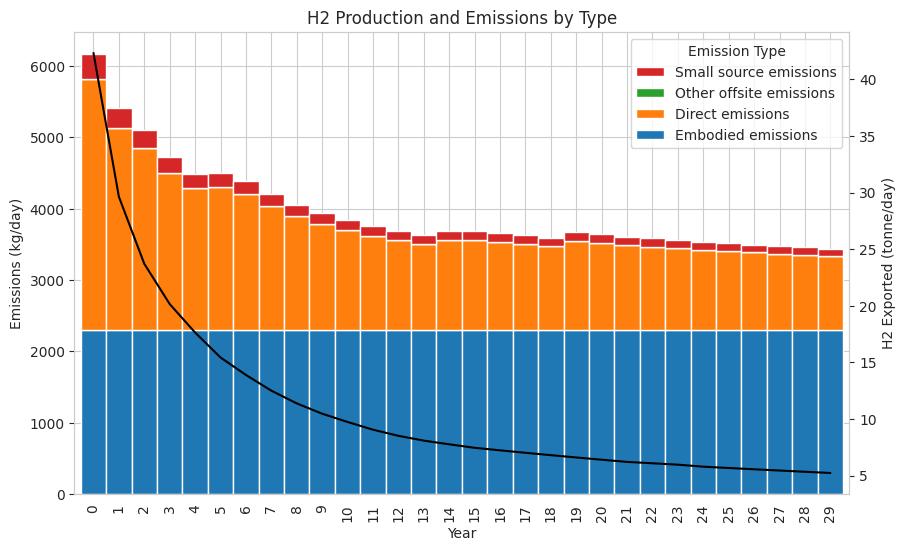

In [116]:
# Plot a vertical stacked bar chart of all the emission types
emissions_df.plot(kind='bar', stacked=True, figsize=(10, 6), width=1)
# Reverse the order of the legend
# plt.gca().get_legend_handles_labels()
plt.legend(plt.gca().get_legend_handles_labels()[0][::-1], reversed(emissions_df.columns), title='Emission Type')
plt.ylabel('Emissions (kg/day)')
plt.xlabel('Year')
plt.title('H2 Production and Emissions by Type')

plt.twinx()
plt.plot(daily_field_H2_exported, color='black', label='H2 Exported')
plt.ylabel('H2 Exported (tonne/day)')
plt.grid(False)

plt.show()

Text(0.5, 1.0, 'Breakdown of Emissions Intensity by Type')

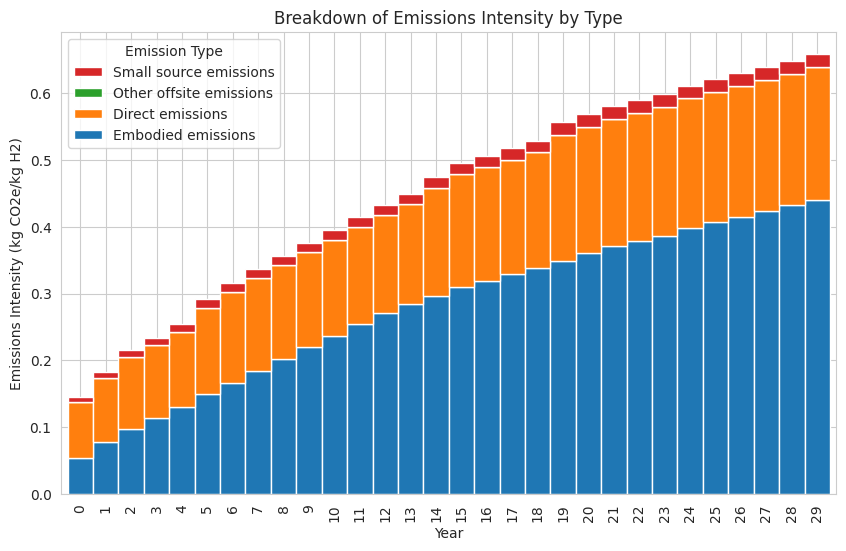

In [111]:
# Plot emissions_df divided by daily_field_H2_exported
emissions_intensity_df = emissions_df.div(daily_field_H2_exported * 1000, axis=0)
emissions_intensity_df.plot(kind='bar', stacked=True, figsize=(10, 6), width=1)
# Reverse the order of the legend
plt.legend(plt.gca().get_legend_handles_labels()[0][::-1], reversed(emissions_intensity_df.columns), title='Emission Type')

plt.ylabel('Emissions Intensity (kg CO2e/kg H2)')
plt.xlabel('Year')
plt.title('Breakdown of Emissions Intensity by Type')

Text(0.5, 1.0, 'Breakdown of Emissions by Type as Percent of Total Emissions')

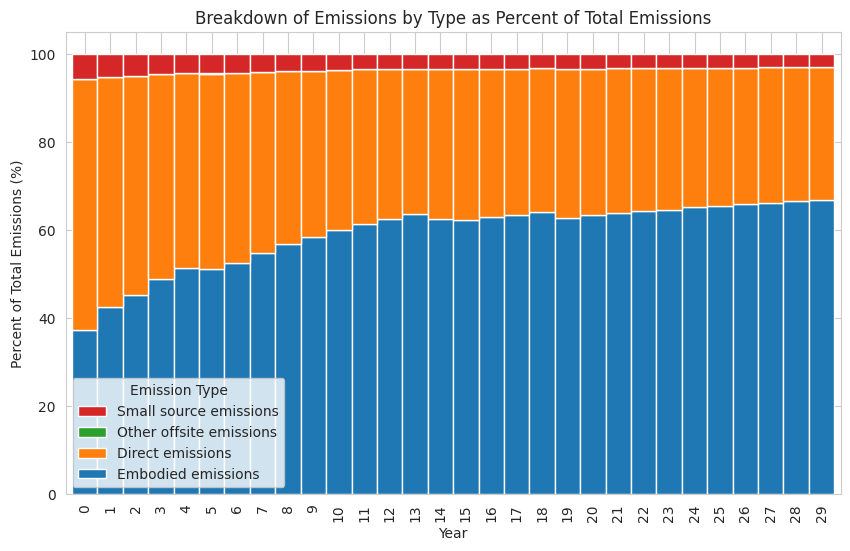

In [112]:
# Plot the emissions as a percent of total emissions
emissions_percent_df = emissions_df.div(total_emissions, axis=0) * 100
emissions_percent_df.plot(kind='bar', stacked=True, figsize=(10, 6), width=1)
# Reverse the order of the legend
plt.legend(plt.gca().get_legend_handles_labels()[0][::-1], reversed(emissions_percent_df.columns), title='Emission Type')

plt.ylabel('Percent of Total Emissions (%)')
plt.xlabel('Year')
plt.title('Breakdown of Emissions by Type as Percent of Total Emissions')

/tmp/ipykernel_57321/525212447.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(data_relative.columns, rotation=45)
/tmp/ipykernel_57321/525212447.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(data_relative.columns, rotation=45)
/tmp/ipykernel_57321/525212447.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(data_relative.columns, rotation=45)


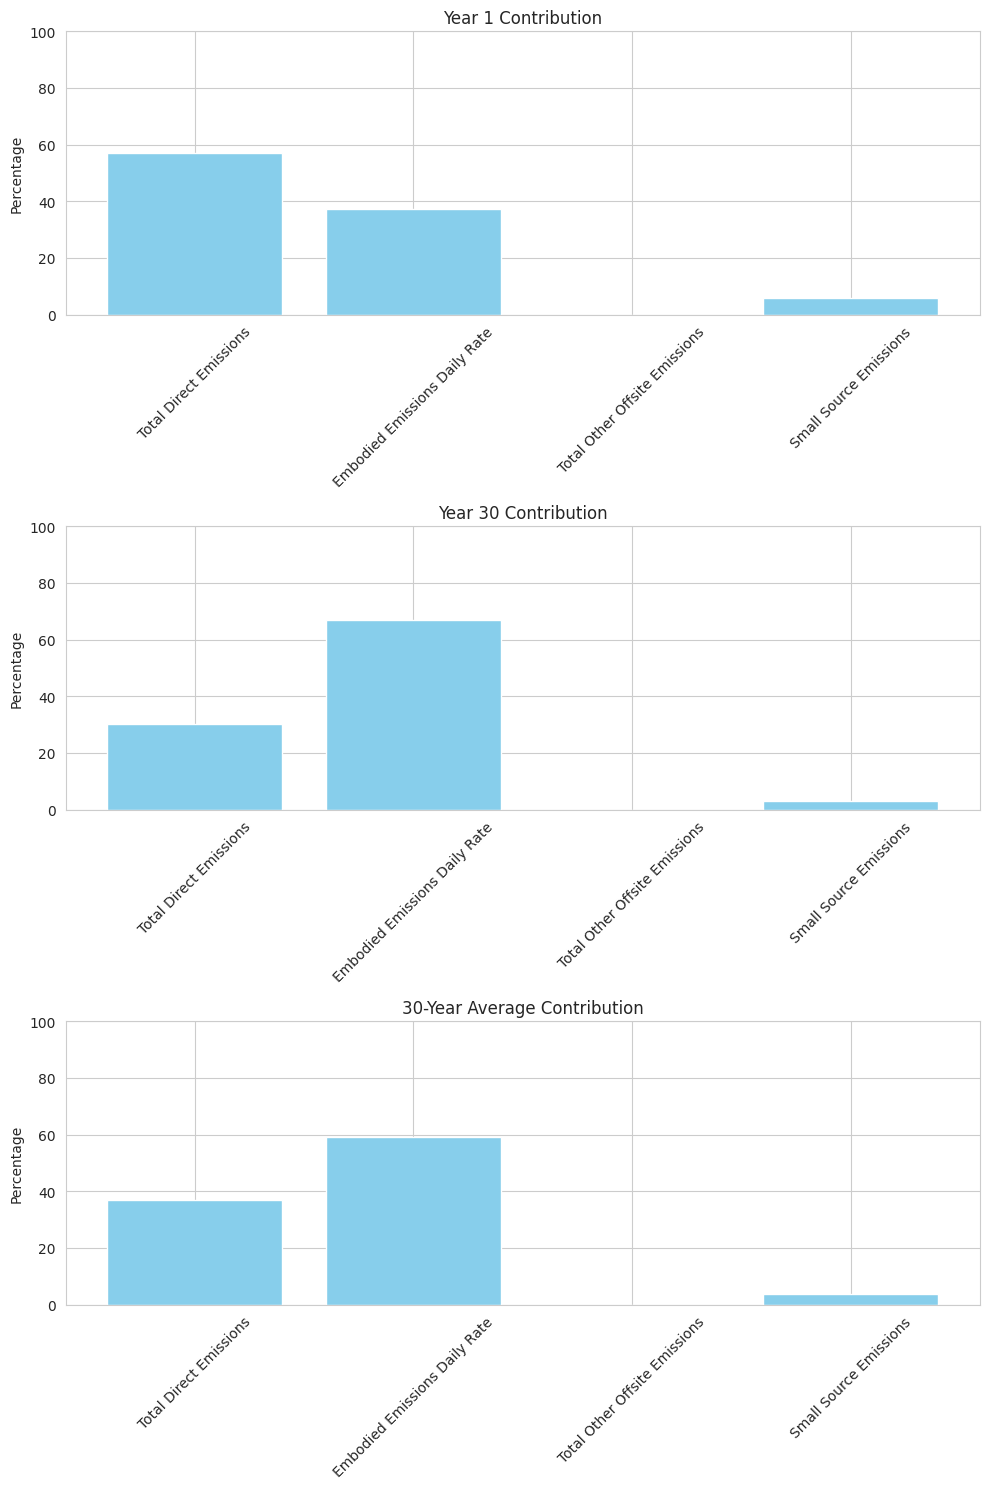

In [113]:
# Creating a Series from a scalar, repeated 30 times
embodied_emissions_daily_rate_series = pd.Series(np.full(30, embodied_emissions_daily_rate))

components = [total_direct_emissions, embodied_emissions_daily_rate_series, total_other_offsite_emissions, small_source_emissions]
component_names = ['Total Direct Emissions', 'Embodied Emissions Daily Rate', 'Total Other Offsite Emissions', 'Small Source Emissions']

# Create a DataFrame for ease of calculations
data = pd.DataFrame({
    'Total Direct Emissions': total_direct_emissions,
    'Embodied Emissions Daily Rate': embodied_emissions_daily_rate_series,
    'Total Other Offsite Emissions': total_other_offsite_emissions,
    'Small Source Emissions': small_source_emissions
})

# Calculate the relative contributions
data_relative = data.div(data.sum(axis=1), axis=0) * 100

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Titles for plots
titles = ['Year 1 Contribution', 'Year 30 Contribution', '30-Year Average Contribution']

# Plot data for the first year, last year, and the average
for i, idx in enumerate([0, -1, None]):  # None will handle the mean case
    if idx is None:
        # Calculate mean across all years
        mean_contributions = data_relative.mean()
        axs[i].bar(mean_contributions.index, mean_contributions, color='skyblue')
    else:
        # Year-specific data
        axs[i].bar(data_relative.columns, data_relative.iloc[idx], color='skyblue')

    axs[i].set_title(titles[i])
    axs[i].set_ylabel('Percentage')
    axs[i].set_ylim(0, 100)  # Ensure y-axis is same for comparison
    axs[i].set_xticklabels(data_relative.columns, rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_57321/2284362556.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(data.columns, rotation=45)
/tmp/ipykernel_57321/2284362556.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(data.columns, rotation=45)
/tmp/ipykernel_57321/2284362556.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(data.columns, rotation=45)


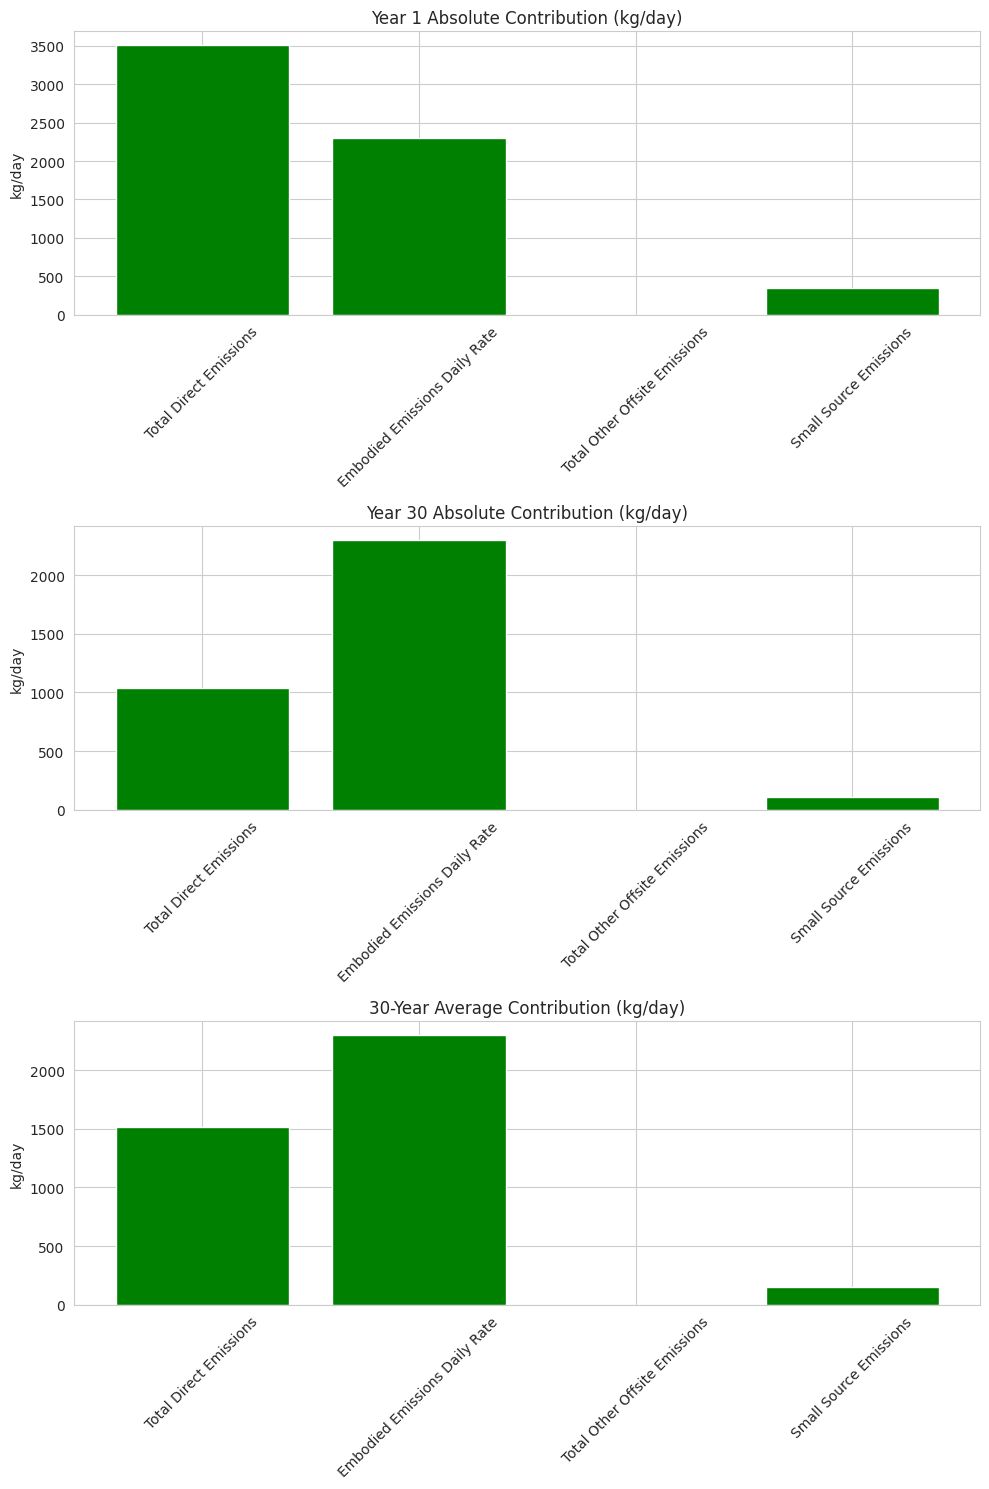

In [114]:
components = [total_direct_emissions, embodied_emissions_daily_rate_series, total_other_offsite_emissions, small_source_emissions]
component_names = ['Total Direct Emissions', 'Embodied Emissions Daily Rate', 'Total Other Offsite Emissions', 'Small Source Emissions']

# Create a DataFrame for ease of calculations
data = pd.DataFrame({
    'Total Direct Emissions': total_direct_emissions,
    'Embodied Emissions Daily Rate': embodied_emissions_daily_rate_series,
    'Total Other Offsite Emissions': total_other_offsite_emissions,
    'Small Source Emissions': small_source_emissions
})

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Titles for plots
titles = ['Year 1 Absolute Contribution (kg/day)', 'Year 30 Absolute Contribution (kg/day)', '30-Year Average Contribution (kg/day)']

# Plot data for the first year, last year, and the average
for i, idx in enumerate([0, -1, None]):  # None will handle the mean case
    if idx is None:
        # Calculate mean across all years
        mean_contributions = data.mean()
        axs[i].bar(mean_contributions.index, mean_contributions, color='green')
    else:
        # Year-specific data
        axs[i].bar(data.columns, data.iloc[idx], color='green')

    axs[i].set_title(titles[i])
    axs[i].set_ylabel('kg/day')
    axs[i].set_xticklabels(data.columns, rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [115]:
print(embodied_emissions_daily_rate_series)
print(embodied_emissions_daily_rate)

0     2302.876936
1     2302.876936
2     2302.876936
3     2302.876936
4     2302.876936
5     2302.876936
6     2302.876936
7     2302.876936
8     2302.876936
9     2302.876936
10    2302.876936
11    2302.876936
12    2302.876936
13    2302.876936
14    2302.876936
15    2302.876936
16    2302.876936
17    2302.876936
18    2302.876936
19    2302.876936
20    2302.876936
21    2302.876936
22    2302.876936
23    2302.876936
24    2302.876936
25    2302.876936
26    2302.876936
27    2302.876936
28    2302.876936
29    2302.876936
dtype: float64
2302.876936347693
